### Description
This is set up to process the unfolding output.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

import pickle


In [2]:

#fitType = 'bin center approximation'
fitType = 'integral within bin'







rcond_val = 0.001

diagonal_constant = 1.0



use_uniform_fit_hist_binning = True

#use_uniform_fit_hist_binning = False


#uniform_fit_hist_nbins = 20
#uniform_fit_hist_xlow = -3.
#uniform_fit_hist_xhigh = 3.

uniform_fit_hist_nbins = 15
uniform_fit_hist_xlow = -3.
uniform_fit_hist_xhigh = 4.



In [3]:

samples_from_GenerateInput = False

#input_unfolding_dir = 'bootstrap-toy-study9d-1d-5c-total-fluctuations-gelu4-res1.50'

input_unfolding_dir = 'output-run-nn-study-nd-v0j-ndim1-res-sf-0.00'

#input_unfolding_dir = 'output-run-kde-study-1d-v0c-res-sf-1.50'

#----

#samples_from_GenerateInput = True

#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.0000'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.1184'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.2368'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.3553'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.5132'
#input_unfolding_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-0.7500'

max_fits = 500


In [4]:

if not samples_from_GenerateInput :

    config_file = '%s/config.txt' % (input_unfolding_dir)

    if not exists(config_file) :

        print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
        sys.exit()

    ndim = int(cu.get_par( config_file, "ndim"))
    print("\n\n Number of feature dimensions: %d\n\n" % ndim)
    
else :

    ndim = 1
    
    

    



 Number of feature dimensions: 1




In [5]:
input_unfolding_dir

'output-run-nn-study-nd-v0j-ndim1-res-sf-0.00'

In [6]:
if not samples_from_GenerateInput :

    with open( '%s/config-pars.pkl' % input_unfolding_dir, 'rb') as f :
        mc_mu = pickle.load(f)
        mc_rho = pickle.load(f)
        mc_sig = pickle.load(f)
        true_mu = pickle.load(f)
        true_rho = pickle.load(f)
        true_sig = pickle.load(f)
        resolution = pickle.load(f)
        mc_cov = pickle.load(f)
        true_cov = pickle.load(f)
        
    print('true_mu : %.3f' % true_mu[0])

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
    
else :
    
    sample_input_dir = cu.get_par( '%s/config.txt' % input_unfolding_dir, 'input_dir')
    print('  sample_input_dir = %s' % sample_input_dir )

    true_mu = np.zeros( shape=(ndim))
    true_cov = np.zeros( shape=(ndim,ndim) )
    true_sig = np.zeros( shape=(ndim))

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'mu_true')
    true_mu[0] = float(pv)

    print('true_mu : %.3f' % true_mu[0])

    pv = cu.get_par( '%s/config.txt' % sample_input_dir,'var_true')
    true_cov[0,0] = float(pv)
    true_sig[0] = np.sqrt(float(pv))

    print('true_cov[0,0] : %.3f' % true_cov[0,0])
        

true_mu : 0.200
true_cov[0,0] : 0.810


In [7]:
n_samples = 0


if not samples_from_GenerateInput :

    for fi in range(5000) :

        fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)

        if exists(fname) :
            n_samples = n_samples + 1
            
else :
    
    for fi in range(5000) :
    
        fname = '%s/sample-%04d.npz' % (sample_input_dir, fi)
    
        if exists(fname) :
            n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [8]:
def read_sample( input_dir, sample_index ) :
    
    with np.load( '%s/sample-%04d.npz' % (input_dir, sample_index) ) as f:
        read_true_det_pts = f['data']
        read_mc_pts = f['gen']
        read_mc_det_pts = f['sim']

    ngen_true = len(read_true_det_pts)
    ngen_mc = len(read_mc_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    mc_pts = np.zeros( shape=(ngen_mc,1) )
    mc_pts[:,0] = read_mc_pts

    mc_det_pts = np.zeros( shape=(ngen_mc,1) )
    mc_det_pts[:,0] = read_mc_det_pts
    
    return_dict = {}
    

    return_dict['true_det_pts'] = true_det_pts
    return_dict['mc_pts'] = mc_pts
    return_dict['mc_det_pts'] = mc_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_mc'] = ngen_mc
    
    return return_dict
    
    

In [9]:
if not samples_from_GenerateInput :

    with open( '%s/mc-and-true-samples.npy' % input_unfolding_dir, 'rb') as f :
        mc_pts = np.load(f)
        mc_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)
        
    print()
    print('mc_pts     shape :  %s ' % str(mc_pts.shape))
    print('mc_det_pts shape :  %s' % str(mc_det_pts.shape))
    print('true_pts      shape :  %s' % str(true_pts.shape))
    print('true_det_pts  shape :  %s' % str(true_det_pts.shape))
    print()


mc_pts     shape :  (100000, 1) 
mc_det_pts shape :  (100000, 1)
true_pts      shape :  (10009, 1)
true_det_pts  shape :  (10009, 1)



## Calculate the model parameters from simple average and covariance from weighted events

In [10]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * mc_pts[:,fi1] )
    wx2 = np.sum( weights * mc_pts[:,fi2] )
    wx1x2 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi1] )
        wx2x2 = np.sum( weights * mc_pts[:,fi2] * mc_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [11]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )


si = 0

for fi in range(n_samples) :
    
    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, fi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']

        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
        
        if fi < 5 :
            print(' mc_pts for sample %d : %s' % (fi, str(mc_pts)))
    

    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            
        print( len(final_push_weights_scaled))
        print( final_push_weights_scaled )


        all_weight_min[si] = np.min( final_push_weights_scaled )
        all_weight_max[si] = np.max( final_push_weights_scaled )

        all_weight_sum[si] = np.sum( final_push_weights_scaled )

        for fi1 in range(ndim) :
            for fi2 in range(fi1,ndim) :
                mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                if ( fi1 == fi2 ) :
                    print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                          (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                    all_mean[fi1,si] = mean_cov["mean_x1"]
                    all_rms[fi1,si] = mean_cov["rms1"]
                else :
                    print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                          (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                    all_rho[fi1,fi2,si] = mean_cov["rho12"]
                    all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-000.npy exists
100000
[0.11428974 0.09193321 0.09471507 ... 0.11041879 0.11626814 0.08698262]
  0 0  :  mean =   0.1871, RMS =   0.8973, cov =   0.8051

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-001.npy exists
100000
[0.11991243 0.08954016 0.09295522 ... 0.1139508  0.11877771 0.08433323]
  0 0  :  mean =   0.2069, RMS =   0.9007, cov =   0.8113

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-002.npy exists
100000
[0.12263551 0.08547915 0.08947734 ... 0.11383704 0.11620012 0.08026313]
  0 0  :  mean =   0.2002, RMS =   0.9071, cov =   0.8228

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-003.npy exists
100000
[0.12758346 0.08391374 0.08795069 ... 0.11528468 0.11973743 0.07819718]
  0 0  :  mean =   0.2309, RMS =   0.9020, cov =   0.8136

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-004.npy exists
100000
[0.11065723 0.085019

100000
[0.12007705 0.08556413 0.08803517 ... 0.10935982 0.11613029 0.08186373]
  0 0  :  mean =   0.2030, RMS =   0.8960, cov =   0.8028

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-249.npy exists
100000
[0.12324957 0.08763084 0.09162945 ... 0.11595129 0.11894967 0.08160538]
  0 0  :  mean =   0.2105, RMS =   0.8911, cov =   0.7941

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-250.npy exists
100000
[0.12235886 0.09047912 0.09302718 ... 0.10815504 0.11284648 0.08631119]
  0 0  :  mean =   0.1980, RMS =   0.9097, cov =   0.8276

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-251.npy exists
100000
[0.1231131  0.0882521  0.09076681 ... 0.10967652 0.11551022 0.08424063]
  0 0  :  mean =   0.1937, RMS =   0.9098, cov =   0.8278

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-252.npy exists
100000
[0.11578966 0.08900974 0.09226841 ... 0.11415349 0.11722664 0.08406786]
  0 0  :  mean =   0.1893, RMS = 

  0 0  :  mean =   0.1932, RMS =   0.9002, cov =   0.8103

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-324.npy exists
100000
[0.11487786 0.09001995 0.09353312 ... 0.11256479 0.11890492 0.08391005]
  0 0  :  mean =   0.2083, RMS =   0.8807, cov =   0.7756

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-325.npy exists
100000
[0.11336754 0.08987409 0.09237912 ... 0.10843006 0.11610276 0.08576116]
  0 0  :  mean =   0.1910, RMS =   0.9000, cov =   0.8099

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-326.npy exists
100000
[0.12210551 0.09126949 0.09404375 ... 0.11067967 0.1181438  0.08638571]
  0 0  :  mean =   0.2103, RMS =   0.9005, cov =   0.8108

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-327.npy exists
100000
[0.12119369 0.09009243 0.09253901 ... 0.11277951 0.11653159 0.08637358]
  0 0  :  mean =   0.2051, RMS =   0.9027, cov =   0.8149

----- output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bo

<function matplotlib.pyplot.show(close=None, block=None)>

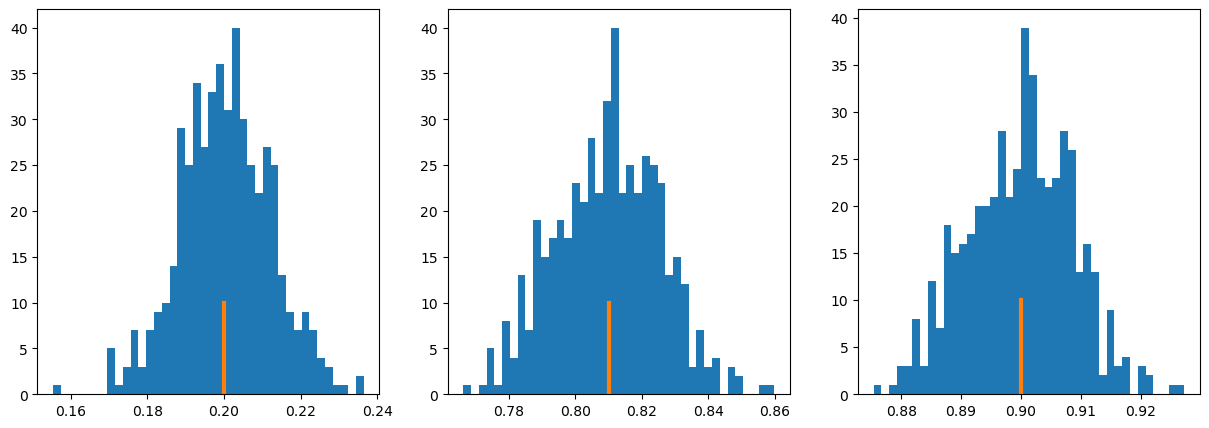

In [12]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

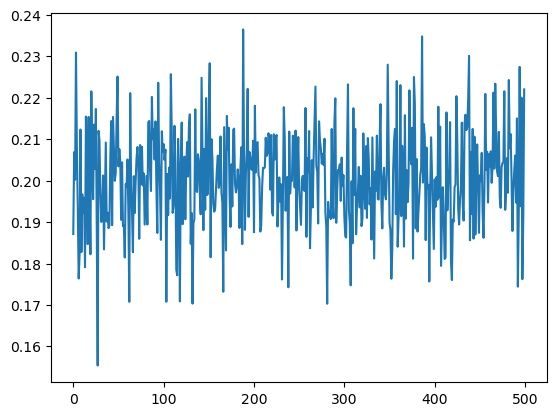

In [13]:
plt.plot(all_mean[0])
plt.show

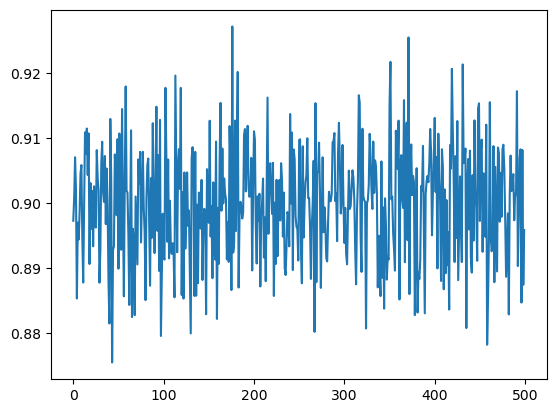

In [14]:
plt.plot(all_rms[0])

<function matplotlib.pyplot.show(close=None, block=None)>

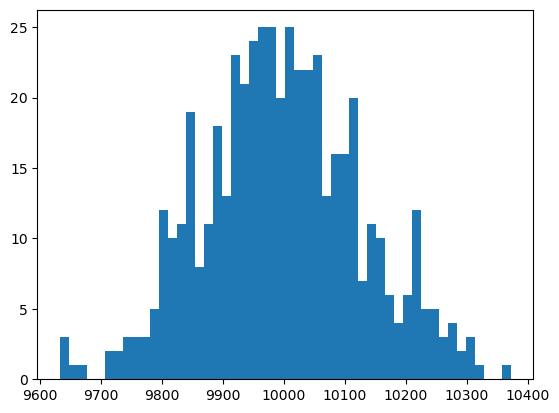

In [15]:
plt.hist( all_weight_sum, bins=50 )
plt.show

In [16]:
print( 'Weight sum RMS: %.1f' % np.sqrt( np.cov(all_weight_sum)))

Weight sum RMS: 129.7


In [17]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.2006  (true   0.2000), rms  0.01182 +/- 0.00037


  feature 0  :  RMS    ave   0.8998  (true   0.9000), rms   0.0087




  feature 0, 0  :  cov    ave   0.8098  (true   0.8100), rms  0.01570 +/- 0.00050




In [18]:
with open( '%s/simple-calc-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [19]:
with open( '%s/simple-calc-per-sample-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, all_mean )
    np.save( f, all_cov )


## Run the unbinned ML fits

In [20]:
import ROOT
import gc

Module libc not found.


Welcome to JupyROOT 6.30/09


In [21]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [22]:
width_factor_mean = 10
width_factor_cov = 10

In [23]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = ave_cov[i][j]
        minval = ave_cov[i][j] - width_factor_cov * rms_cov[i][j]
        maxval = ave_cov[i][j] + width_factor_cov * rms_cov[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        

 parameter cov00  min   0.6528, max   0.9668
RooRealVar::cov00 = 0.80979  L(0.652785 - 0.966794) 


In [24]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [25]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.810


In [26]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = ave_mean[i]
    minval = ave_mean[i] - width_factor_mean * rms_mean[i]
    maxval = ave_mean[i] + width_factor_mean * rms_mean[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.0824, max   0.3188
RooRealVar::mu_x0 = 0.20058  L(0.0823523 - 0.318808) 


In [27]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.809790
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8098 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.235 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [28]:




n_fits = np.min( (n_samples, max_fits) )

print('\n\n Will fit %d samples\n\n' % n_fits )

fit_results_mean_val = np.zeros( shape=(ndim, n_fits ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_fits ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_fits ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_fits ) )



 Will fit 500 samples




In [29]:
%%time



for bi in range( n_fits ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()

    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, bi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']

        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
    
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( mc_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1872   (true   0.2000) err   0.0089  diff  -0.0128   diff/err  -1.44


  0,  0 :  cov    0.8053  (true   0.8100) err   0.0113  diff  -0.0047   diff/err  -0.42
Cleaning up.


 --- bootstrap sample   1
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2069   (true   0.2000) err   0.0089  diff   0.0069   diff/err   0.78


  0,  0 :  cov    0.8114  (true   0.8100) err   0.0113  diff   0.0014   diff/err   0.12
Cleaning up.


 --- bootstrap sample   2
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2002   (true   0.2000) err   0.0090  diff   0.0002   diff/err   0.02


  0

  Running fit...
   0 :  mu =   0.1955   (true   0.2000) err   0.0090  diff  -0.0045   diff/err  -0.50


  0,  0 :  cov    0.7981  (true   0.8100) err   0.0113  diff  -0.0119   diff/err  -1.05
Cleaning up.


 --- bootstrap sample  23
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-023.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2135   (true   0.2000) err   0.0090  diff   0.0135   diff/err   1.50


  0,  0 :  cov    0.8147  (true   0.8100) err   0.0115  diff   0.0047   diff/err   0.40
Cleaning up.


 --- bootstrap sample  24
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2027   (true   0.2000) err   0.0089  diff   0.0027   diff/err   0.31


  0,  0 :  cov    0.8038  (true   0.8100) err   0.0113  diff  -0.0062   diff/err  -0.55
Cleaning up.


 --- bootstrap sample  25
Reading weights file : output-run-

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-045.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2073   (true   0.2000) err   0.0090  diff   0.0073   diff/err   0.82


  0,  0 :  cov    0.7981  (true   0.8100) err   0.0113  diff  -0.0119   diff/err  -1.05
Cleaning up.


 --- bootstrap sample  46
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-046.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1999   (true   0.2000) err   0.0090  diff  -0.0001   diff/err  -0.01


  0,  0 :  cov    0.8236  (true   0.8100) err   0.0116  diff   0.0136   diff/err   1.18
Cleaning up.


 --- bootstrap sample  47
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-047.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2019   (true   0.2000) err   0.0091  diff   0.0019   diff/err   0.21


  0,  0 :  cov    0.8163  (true

   0 :  mu =   0.2011   (true   0.2000) err   0.0088  diff   0.0011   diff/err   0.12


  0,  0 :  cov    0.7988  (true   0.8100) err   0.0112  diff  -0.0112   diff/err  -1.00
Cleaning up.


 --- bootstrap sample  68
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-068.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1922   (true   0.2000) err   0.0089  diff  -0.0078   diff/err  -0.88


  0,  0 :  cov    0.7792  (true   0.8100) err   0.0111  diff  -0.0308   diff/err  -2.76
Cleaning up.


 --- bootstrap sample  69
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-069.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1997   (true   0.2000) err   0.0089  diff  -0.0003   diff/err  -0.04


  0,  0 :  cov    0.8119  (true   0.8100) err   0.0113  diff   0.0019   diff/err   0.17
Cleaning up.


 --- bootstrap sample  70
Reading weights file : output-run-nn-study-nd-v0j-n

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-090.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2050   (true   0.2000) err   0.0089  diff   0.0050   diff/err   0.56


  0,  0 :  cov    0.7962  (true   0.8100) err   0.0113  diff  -0.0138   diff/err  -1.22
Cleaning up.


 --- bootstrap sample  91
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-091.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2143   (true   0.2000) err   0.0090  diff   0.0143   diff/err   1.58


  0,  0 :  cov    0.8152  (true   0.8100) err   0.0115  diff   0.0052   diff/err   0.45
Cleaning up.


 --- bootstrap sample  92
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-092.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1982   (true   0.2000) err   0.0091  diff  -0.0018   diff/err  -0.20


  0,  0 :  cov    0.8370  (true

   0 :  mu =   0.2132   (true   0.2000) err   0.0089  diff   0.0132   diff/err   1.50


  0,  0 :  cov    0.7840  (true   0.8100) err   0.0111  diff  -0.0260   diff/err  -2.34
Cleaning up.


 --- bootstrap sample 113
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-113.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2041   (true   0.2000) err   0.0092  diff   0.0041   diff/err   0.45


  0,  0 :  cov    0.8458  (true   0.8100) err   0.0120  diff   0.0358   diff/err   2.98
Cleaning up.


 --- bootstrap sample 114
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-114.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1785   (true   0.2000) err   0.0090  diff  -0.0215   diff/err  -2.39


  0,  0 :  cov    0.8201  (true   0.8100) err   0.0115  diff   0.0101   diff/err   0.88
Cleaning up.


 --- bootstrap sample 115
Reading weights file : output-run-nn-study-nd-v0j-n



 --- bootstrap sample 135
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-135.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2172   (true   0.2000) err   0.0091  diff   0.0172   diff/err   1.90


  0,  0 :  cov    0.8243  (true   0.8100) err   0.0116  diff   0.0143   diff/err   1.23
Cleaning up.


 --- bootstrap sample 136
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-136.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1979   (true   0.2000) err   0.0087  diff  -0.0021   diff/err  -0.24


  0,  0 :  cov    0.7845  (true   0.8100) err   0.0110  diff  -0.0255   diff/err  -2.33
Cleaning up.


 --- bootstrap sample 137
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-137.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1973   (true   0.2000) err   0.0090  diff  -0.0027   diff/err  -0.30


  0

  Running fit...
   0 :  mu =   0.1932   (true   0.2000) err   0.0088  diff  -0.0068   diff/err  -0.77


  0,  0 :  cov    0.7944  (true   0.8100) err   0.0111  diff  -0.0156   diff/err  -1.40
Cleaning up.


 --- bootstrap sample 158
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-158.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1980   (true   0.2000) err   0.0091  diff  -0.0020   diff/err  -0.22


  0,  0 :  cov    0.8272  (true   0.8100) err   0.0117  diff   0.0172   diff/err   1.46
Cleaning up.


 --- bootstrap sample 159
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-159.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2031   (true   0.2000) err   0.0088  diff   0.0031   diff/err   0.35


  0,  0 :  cov    0.7782  (true   0.8100) err   0.0110  diff  -0.0318   diff/err  -2.88
Cleaning up.


 --- bootstrap sample 160
Reading weights file : output-run-

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-180.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1972   (true   0.2000) err   0.0089  diff  -0.0028   diff/err  -0.32


  0,  0 :  cov    0.8023  (true   0.8100) err   0.0113  diff  -0.0077   diff/err  -0.69
Cleaning up.


 --- bootstrap sample 181
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-181.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1986   (true   0.2000) err   0.0091  diff  -0.0014   diff/err  -0.16


  0,  0 :  cov    0.8268  (true   0.8100) err   0.0117  diff   0.0168   diff/err   1.44
Cleaning up.


 --- bootstrap sample 182
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-182.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2027   (true   0.2000) err   0.0092  diff   0.0027   diff/err   0.30


  0,  0 :  cov    0.8468  (true

   0 :  mu =   0.2020   (true   0.2000) err   0.0090  diff   0.0020   diff/err   0.22


  0,  0 :  cov    0.8038  (true   0.8100) err   0.0114  diff  -0.0062   diff/err  -0.54
Cleaning up.


 --- bootstrap sample 203
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-203.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2090   (true   0.2000) err   0.0090  diff   0.0090   diff/err   1.01


  0,  0 :  cov    0.7934  (true   0.8100) err   0.0113  diff  -0.0166   diff/err  -1.47
Cleaning up.


 --- bootstrap sample 204
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-204.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2093   (true   0.2000) err   0.0089  diff   0.0093   diff/err   1.04


  0,  0 :  cov    0.8119  (true   0.8100) err   0.0114  diff   0.0019   diff/err   0.16
Cleaning up.


 --- bootstrap sample 205
Reading weights file : output-run-nn-study-nd-v0j-n

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-225.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2110   (true   0.2000) err   0.0090  diff   0.0110   diff/err   1.22


  0,  0 :  cov    0.8165  (true   0.8100) err   0.0115  diff   0.0065   diff/err   0.56
Cleaning up.


 --- bootstrap sample 226
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-226.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1889   (true   0.2000) err   0.0089  diff  -0.0111   diff/err  -1.24


  0,  0 :  cov    0.7953  (true   0.8100) err   0.0112  diff  -0.0147   diff/err  -1.31
Cleaning up.


 --- bootstrap sample 227
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-227.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1953   (true   0.2000) err   0.0091  diff  -0.0047   diff/err  -0.52


  0,  0 :  cov    0.8084  (true

   0 :  mu =   0.1880   (true   0.2000) err   0.0090  diff  -0.0120   diff/err  -1.34


  0,  0 :  cov    0.8034  (true   0.8100) err   0.0114  diff  -0.0066   diff/err  -0.58
Cleaning up.


 --- bootstrap sample 248
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-248.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2030   (true   0.2000) err   0.0090  diff   0.0030   diff/err   0.33


  0,  0 :  cov    0.8028  (true   0.8100) err   0.0114  diff  -0.0072   diff/err  -0.63
Cleaning up.


 --- bootstrap sample 249
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-249.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2105   (true   0.2000) err   0.0088  diff   0.0105   diff/err   1.19


  0,  0 :  cov    0.7942  (true   0.8100) err   0.0111  diff  -0.0158   diff/err  -1.42
Cleaning up.


 --- bootstrap sample 250
Reading weights file : output-run-nn-study-nd-v0j-n



 --- bootstrap sample 270
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-270.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2021   (true   0.2000) err   0.0090  diff   0.0021   diff/err   0.24


  0,  0 :  cov    0.8186  (true   0.8100) err   0.0115  diff   0.0086   diff/err   0.74
Cleaning up.


 --- bootstrap sample 271
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-271.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1897   (true   0.2000) err   0.0090  diff  -0.0103   diff/err  -1.15


  0,  0 :  cov    0.8190  (true   0.8100) err   0.0115  diff   0.0090   diff/err   0.78
Cleaning up.


 --- bootstrap sample 272
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-272.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2143   (true   0.2000) err   0.0090  diff   0.0143   diff/err   1.59


  0

  Running fit...
   0 :  mu =   0.1974   (true   0.2000) err   0.0090  diff  -0.0026   diff/err  -0.30


  0,  0 :  cov    0.7995  (true   0.8100) err   0.0113  diff  -0.0105   diff/err  -0.92
Cleaning up.


 --- bootstrap sample 293
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-293.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2026   (true   0.2000) err   0.0092  diff   0.0026   diff/err   0.28


  0,  0 :  cov    0.8237  (true   0.8100) err   0.0117  diff   0.0137   diff/err   1.16
Cleaning up.


 --- bootstrap sample 294
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-294.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2026   (true   0.2000) err   0.0092  diff   0.0026   diff/err   0.28


  0,  0 :  cov    0.8325  (true   0.8100) err   0.0119  diff   0.0225   diff/err   1.88
Cleaning up.


 --- bootstrap sample 295
Reading weights file : output-run-



 --- bootstrap sample 315
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-315.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1974   (true   0.2000) err   0.0091  diff  -0.0026   diff/err  -0.29


  0,  0 :  cov    0.8162  (true   0.8100) err   0.0116  diff   0.0062   diff/err   0.53
Cleaning up.


 --- bootstrap sample 316
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-316.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2033   (true   0.2000) err   0.0091  diff   0.0033   diff/err   0.36


  0,  0 :  cov    0.8402  (true   0.8100) err   0.0118  diff   0.0302   diff/err   2.55
Cleaning up.


 --- bootstrap sample 317
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-317.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1935   (true   0.2000) err   0.0091  diff  -0.0065   diff/err  -0.71


  0

  Running fit...
   0 :  mu =   0.1956   (true   0.2000) err   0.0088  diff  -0.0044   diff/err  -0.50


  0,  0 :  cov    0.7868  (true   0.8100) err   0.0111  diff  -0.0232   diff/err  -2.10
Cleaning up.


 --- bootstrap sample 338
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-338.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1954   (true   0.2000) err   0.0090  diff  -0.0046   diff/err  -0.51


  0,  0 :  cov    0.8009  (true   0.8100) err   0.0113  diff  -0.0091   diff/err  -0.80
Cleaning up.


 --- bootstrap sample 339
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-339.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2093   (true   0.2000) err   0.0089  diff   0.0093   diff/err   1.05


  0,  0 :  cov    0.7912  (true   0.8100) err   0.0112  diff  -0.0188   diff/err  -1.68
Cleaning up.


 --- bootstrap sample 340
Reading weights file : output-run-

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-360.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1911   (true   0.2000) err   0.0091  diff  -0.0089   diff/err  -0.97


  0,  0 :  cov    0.8331  (true   0.8100) err   0.0118  diff   0.0231   diff/err   1.96
Cleaning up.


 --- bootstrap sample 361
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-361.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1963   (true   0.2000) err   0.0087  diff  -0.0037   diff/err  -0.42


  0,  0 :  cov    0.7835  (true   0.8100) err   0.0109  diff  -0.0265   diff/err  -2.42
Cleaning up.


 --- bootstrap sample 362
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-362.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2231   (true   0.2000) err   0.0090  diff   0.0231   diff/err   2.55


  0,  0 :  cov    0.8207  (true

   0 :  mu =   0.1926   (true   0.2000) err   0.0088  diff  -0.0074   diff/err  -0.83


  0,  0 :  cov    0.7910  (true   0.8100) err   0.0111  diff  -0.0190   diff/err  -1.71
Cleaning up.


 --- bootstrap sample 383
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-383.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1967   (true   0.2000) err   0.0089  diff  -0.0033   diff/err  -0.37


  0,  0 :  cov    0.7891  (true   0.8100) err   0.0112  diff  -0.0209   diff/err  -1.87
Cleaning up.


 --- bootstrap sample 384
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-384.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2014   (true   0.2000) err   0.0089  diff   0.0014   diff/err   0.15


  0,  0 :  cov    0.7943  (true   0.8100) err   0.0112  diff  -0.0157   diff/err  -1.40
Cleaning up.


 --- bootstrap sample 385
Reading weights file : output-run-nn-study-nd-v0j-n

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-405.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1960   (true   0.2000) err   0.0090  diff  -0.0040   diff/err  -0.45


  0,  0 :  cov    0.8172  (true   0.8100) err   0.0115  diff   0.0072   diff/err   0.62
Cleaning up.


 --- bootstrap sample 406
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-406.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2131   (true   0.2000) err   0.0090  diff   0.0131   diff/err   1.46


  0,  0 :  cov    0.8106  (true   0.8100) err   0.0115  diff   0.0006   diff/err   0.05
Cleaning up.


 --- bootstrap sample 407
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-407.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1794   (true   0.2000) err   0.0089  diff  -0.0206   diff/err  -2.32


  0,  0 :  cov    0.7885  (true

   0 :  mu =   0.1894   (true   0.2000) err   0.0088  diff  -0.0106   diff/err  -1.20


  0,  0 :  cov    0.8023  (true   0.8100) err   0.0111  diff  -0.0077   diff/err  -0.69
Cleaning up.


 --- bootstrap sample 428
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-428.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1954   (true   0.2000) err   0.0090  diff  -0.0046   diff/err  -0.50


  0,  0 :  cov    0.8175  (true   0.8100) err   0.0115  diff   0.0075   diff/err   0.65
Cleaning up.


 --- bootstrap sample 429
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-429.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1988   (true   0.2000) err   0.0089  diff  -0.0012   diff/err  -0.13


  0,  0 :  cov    0.8040  (true   0.8100) err   0.0113  diff  -0.0060   diff/err  -0.53
Cleaning up.


 --- bootstrap sample 430
Reading weights file : output-run-nn-study-nd-v0j-n

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-450.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2013   (true   0.2000) err   0.0091  diff   0.0013   diff/err   0.14


  0,  0 :  cov    0.8050  (true   0.8100) err   0.0115  diff  -0.0050   diff/err  -0.43
Cleaning up.


 --- bootstrap sample 451
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-451.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1999   (true   0.2000) err   0.0090  diff  -0.0001   diff/err  -0.01


  0,  0 :  cov    0.8245  (true   0.8100) err   0.0116  diff   0.0145   diff/err   1.25
Cleaning up.


 --- bootstrap sample 452
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-452.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2067   (true   0.2000) err   0.0090  diff   0.0067   diff/err   0.74


  0,  0 :  cov    0.8278  (true

   0 :  mu =   0.1958   (true   0.2000) err   0.0090  diff  -0.0042   diff/err  -0.46


  0,  0 :  cov    0.8048  (true   0.8100) err   0.0115  diff  -0.0052   diff/err  -0.45
Cleaning up.


 --- bootstrap sample 473
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-473.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1935   (true   0.2000) err   0.0090  diff  -0.0065   diff/err  -0.73


  0,  0 :  cov    0.8184  (true   0.8100) err   0.0115  diff   0.0084   diff/err   0.73
Cleaning up.


 --- bootstrap sample 474
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-474.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2034   (true   0.2000) err   0.0090  diff   0.0034   diff/err   0.38


  0,  0 :  cov    0.8063  (true   0.8100) err   0.0114  diff  -0.0037   diff/err  -0.33
Cleaning up.


 --- bootstrap sample 475
Reading weights file : output-run-nn-study-nd-v0j-n

Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-495.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1938   (true   0.2000) err   0.0091  diff  -0.0062   diff/err  -0.68


  0,  0 :  cov    0.8250  (true   0.8100) err   0.0116  diff   0.0150   diff/err   1.29
Cleaning up.


 --- bootstrap sample 496
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-496.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.2201   (true   0.2000) err   0.0089  diff   0.0201   diff/err   2.27


  0,  0 :  cov    0.7826  (true   0.8100) err   0.0111  diff  -0.0274   diff/err  -2.47
Cleaning up.


 --- bootstrap sample 497
Reading weights file : output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-497.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.1762   (true   0.2000) err   0.0092  diff  -0.0238   diff/err  -2.60


  0,  0 :  cov    0.8248  (true

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14310.49367 Edm =  -2.750989134e-07 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13244.41455
  Edm           : 1.13626871
  Internal parameters:	[   -0.02882119279                0]	
  Internal gradient  :	[   -0.01551092818      19.96540673]	
  Internal covariance matrix:
[[    0.010421228              0]
 [              0     0.01140209]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13244.41455
  Edm           : 1.13626871
  Internal parameters:	[   -0.02882119279                0]	
  Internal gradient  :	[   -0.01551092818      19.96540673]	
  Internal covariance matrix:
[[    0.010421228              0]
 [              0     0.01140209]]]
Info in <M

In [30]:
with open( '%s/fit-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

In [31]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 500,   n_fit = 500,   n_for_plot = 500


   0 : x axis limits:  0.151, 0.241    y axis limits  0.151, 0.241


<function matplotlib.pyplot.show(close=None, block=None)>

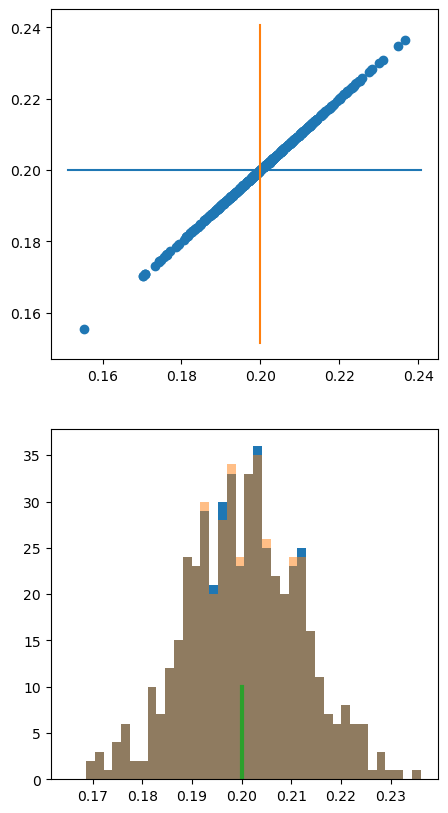

In [32]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [33]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [34]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

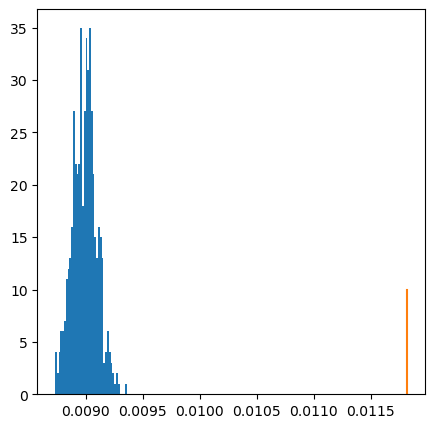

In [35]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [36]:
fit_results_mean_err

array([[0.00891819, 0.00889995, 0.00902961, 0.00893775, 0.00890316,
        0.00913026, 0.00888508, 0.00900178, 0.00891775, 0.00914364,
        0.0090987 , 0.00883863, 0.00892138, 0.00903545, 0.00904327,
        0.00902979, 0.00904609, 0.00904727, 0.0088777 , 0.00892452,
        0.00894742, 0.00899783, 0.00898159, 0.00904107, 0.00893657,
        0.00894581, 0.00902963, 0.00907261, 0.00908343, 0.00889315,
        0.0088955 , 0.00903779, 0.00903491, 0.00901823, 0.00904701,
        0.00908956, 0.00899213, 0.00907564, 0.00906055, 0.00895799,
        0.00875872, 0.00914308, 0.0090286 , 0.00882182, 0.00887803,
        0.00895154, 0.00901883, 0.00905236, 0.00895656, 0.00905152,
        0.00890667, 0.00912133, 0.00898394, 0.00888611, 0.00911638,
        0.0090511 , 0.00886599, 0.00905478, 0.00917175, 0.00904059,
        0.00889913, 0.00897636, 0.00885773, 0.0088444 , 0.00905545,
        0.00886096, 0.0089911 , 0.00884585, 0.00891039, 0.00888416,
        0.0088895 , 0.00892539, 0.00907074, 0.00

<function matplotlib.pyplot.show(close=None, block=None)>

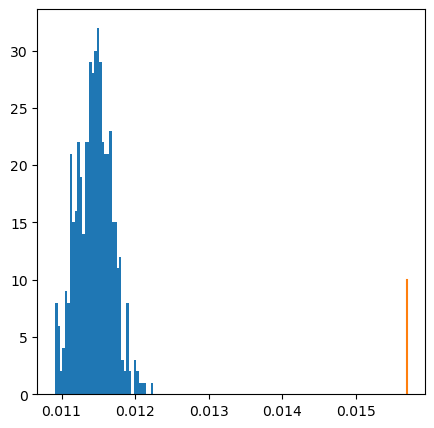

In [37]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

In [38]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')




  toy fits mu   ave. val   0.2006,  true  0.2000
  toy fits sig2 ave. val   0.8098,  true  0.8100



  toy fits mu   RMS:   0.0118,  ave fit err  0.0090
  toy fits sig2 RMS:   0.0157,  ave fit err  0.0114





In [39]:


with open( '%s/fit-results.npy' % input_unfolding_dir, 'rb' ) as f :
    fit_results_mean_val = np.load(f, allow_pickle=True )
    fit_results_mean_err = np.load(f, allow_pickle=True )
    fit_results_cov_val = np.load(f, allow_pickle=True )
    fit_results_cov_err = np.load(f, allow_pickle=True )        


ave_fit_err_mean = np.zeros( ndim )

ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

for fi in range(ndim) :

    ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])

    print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :


        ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])

        print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))


0 : ave fit error, mean :    0.0090
fi1, fi2 : 0, 0    ave fit error, cov :   0.0114


In [40]:
err_ratio = []

for fi in range(ndim) :
    err_ratio.append( rms_mean[fi] / ave_fit_err_mean[fi] )
    
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        err_ratio.append( rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2] )

In [41]:
with open( '%s/parameter-uncertainty-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, rms_mean )
    np.save( f, rms_cov )
    np.save( f, ave_fit_err_mean )
    np.save( f, ave_fit_err_cov )
    np.save( f, err_ratio )

<function matplotlib.pyplot.show(close=None, block=None)>

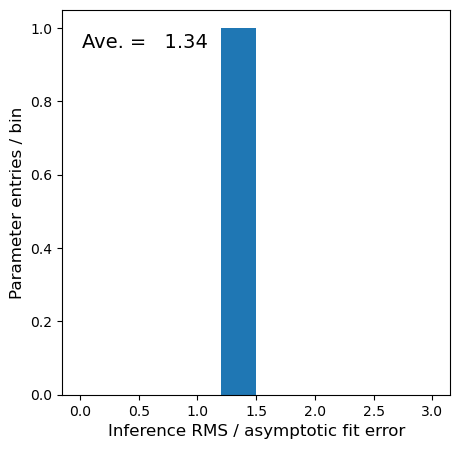

In [42]:
fig,ax = plt.subplots( 1, 1, figsize=(5,1*5))


plt.subplots_adjust( wspace=0.30, hspace=0.30)

ax.hist( err_ratio, bins=20, range=[0., 3.])

#ax.set_title( 'NN, poor resolution')
ax.set_xlabel( 'Inference RMS / asymptotic fit error', fontsize=12)
ax.set_ylabel( 'Parameter entries / bin', fontsize=12 )

ylim = ax.get_ylim()
xlim = ax.get_xlim()

tx = xlim[0] + 0.05 * (xlim[1] - xlim[0])
ty = ylim[0] + 0.90 * (ylim[1] - ylim[0])

ave_val = np.mean( err_ratio )

ax.text( tx, ty, 'Ave. = %6.2f' % ave_val, fontsize=14 )

plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

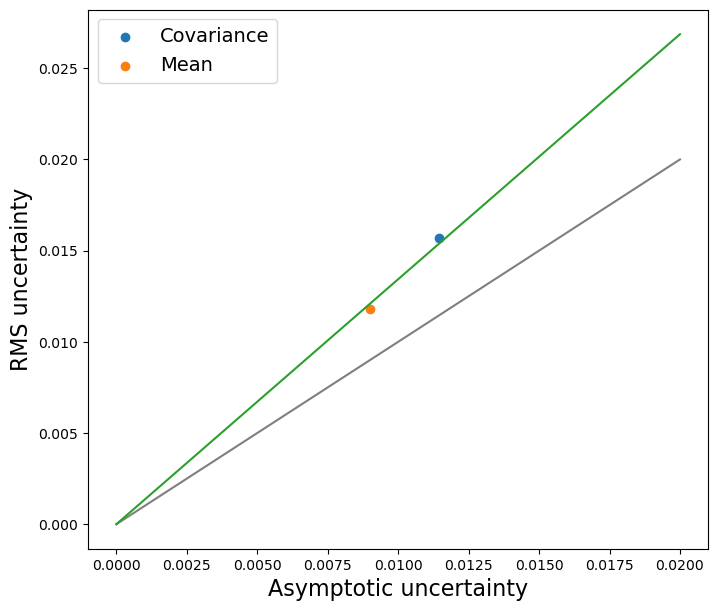

In [43]:
fig,ax = plt.subplots( 1, 1, figsize=(8*1,7*1))




axi = ax

axi.plot( [0,0.02], [0,0.02], color='tab:grey')
axi.plot( [0,0.02], [0,0.02*ave_val], color='tab:green')

axi.scatter( ave_fit_err_cov.flatten(), rms_cov.flatten(), color='tab:blue', label='Covariance' )
axi.scatter( ave_fit_err_mean, rms_mean, color='tab:orange', label='Mean' )



axi.set_xlabel( 'Asymptotic uncertainty', fontsize=16 )
axi.set_ylabel( 'RMS uncertainty', fontsize=16 )

axi.legend( fontsize=14 )


plt.show

In [44]:
def trunc_rms( vals, ratio_threshold=1.015, lverb=False ) :
    
    diffs = vals - np.mean( vals )
    
    rms0 = np.sqrt( np.cov(diffs) )
    if lverb : print('  RMS for all %d is %.5f' % (len(vals), rms0))
    
    dsub = diffs
    prevrms = rms0
    
    for i in range(6) :
        dmask = np.ones( len(dsub), dtype=bool )
        dmask[ np.argmax( np.abs(dsub)) ] = False
        removed_val = dsub[ np.argmax( np.abs(dsub)) ]
        dsub = dsub[dmask]
        subrms = np.sqrt( np.cov( dsub ))
        rmsratio = prevrms / subrms  
        if lverb :
            print( ' %3d  removed val %7.4f,  RMS old %.5f,  RMS new %.5f   ratio %.3f' % 
              (i, removed_val, prevrms, subrms, rmsratio ))
        if rmsratio < ratio_threshold :
            return prevrms

        prevrms = subrms
        
    return subrms
   

In [45]:
rms_mean_trunc = np.copy( rms_mean )
for i in range(ndim) :
    rms_mean_trunc[i] = trunc_rms( all_mean[i] )
    print('-- Mean %d' % i)
    print('  all RMS  %.5f,  trunc RMS  %.5f' % ( rms_mean[i], rms_mean_trunc[i] ) )


-- Mean 0
  all RMS  0.01182,  trunc RMS  0.01183


In [46]:
rms_cov_trunc = np.copy( rms_cov )
for i in range(ndim) :
    for j in range(i,ndim) :
        rms_cov_trunc[i,j] = trunc_rms( all_cov[i,j] )
        print('-- Cov %d, %d' % (i,j))
        print('  all RMS  %.5f,  trunc RMS  %.5f' % (rms_cov[i,j], rms_cov_trunc[i,j] ) )

-- Cov 0, 0
  all RMS  0.01570,  trunc RMS  0.01572


In [47]:
err_ratio_trunc = []

for fi in range(ndim) :
    err_ratio_trunc.append( rms_mean_trunc[fi] / ave_fit_err_mean[fi] )
    
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        err_ratio_trunc.append( rms_cov_trunc[fi1,fi2]/ave_fit_err_cov[fi1,fi2] )

<function matplotlib.pyplot.show(close=None, block=None)>

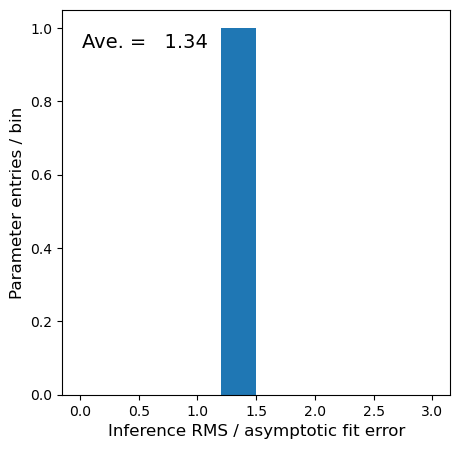

In [48]:
fig,ax = plt.subplots( 1, 1, figsize=(5,1*5))


plt.subplots_adjust( wspace=0.30, hspace=0.30)

ax.hist( err_ratio_trunc, bins=20, range=[0., 3.])

#ax.set_title( 'NN, poor resolution')
ax.set_xlabel( 'Inference RMS / asymptotic fit error', fontsize=12)
ax.set_ylabel( 'Parameter entries / bin', fontsize=12 )

ylim = ax.get_ylim()
xlim = ax.get_xlim()

tx = xlim[0] + 0.05 * (xlim[1] - xlim[0])
ty = ylim[0] + 0.90 * (ylim[1] - ylim[0])

ave_val_trunc = np.mean( err_ratio_trunc )

ax.text( tx, ty, 'Ave. = %6.2f' % ave_val_trunc, fontsize=14 )

plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

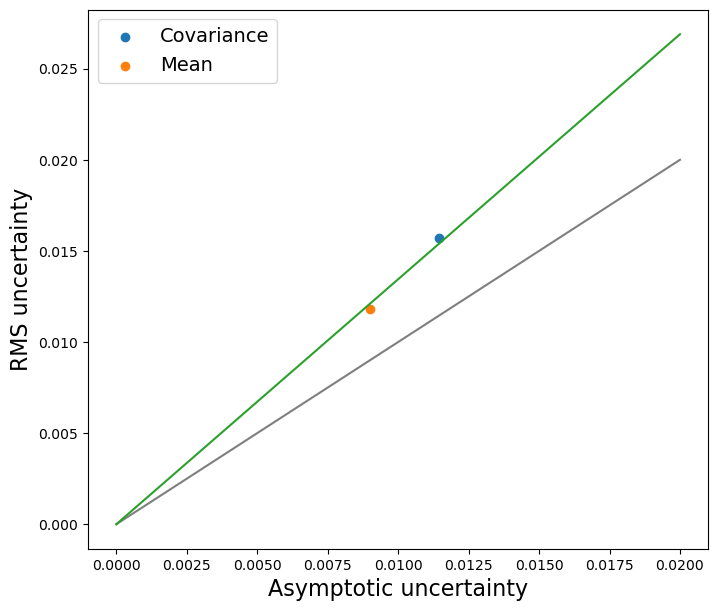

In [49]:
fig,ax = plt.subplots( 1, 1, figsize=(8*1,7*1))




axi = ax

axi.plot( [0,0.02], [0,0.02], color='tab:grey')
axi.plot( [0,0.02], [0,0.02*ave_val_trunc], color='tab:green')

axi.scatter( ave_fit_err_cov.flatten(), rms_cov_trunc.flatten(), color='tab:blue', label='Covariance' )
axi.scatter( ave_fit_err_mean, rms_mean_trunc, color='tab:orange', label='Mean' )



axi.set_xlabel( 'Asymptotic uncertainty', fontsize=16 )
axi.set_ylabel( 'RMS uncertainty', fontsize=16 )

axi.legend( fontsize=14 )


plt.show

In [50]:
with open( '%s/parameter-uncertainty-results-trunc.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, rms_mean_trunc )
    np.save( f, rms_cov_trunc )
    np.save( f, ave_fit_err_mean )
    np.save( f, ave_fit_err_cov )
    np.save( f, err_ratio_trunc )

## Calculate the event weight correlations

In [51]:

ncalc = 1000
npoints = 1000

max_count = ncalc
if npoints > ncalc : max_count = npoints


In [52]:
bootstrap_weights = np.zeros( shape = (n_samples, max_count) )

In [53]:
for fi in range(n_samples) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, fi)
    
    if exists(fname) :
        print( 'loading %s' % fname )
        with open(fname,'rb') as f :
            this_bootstrap_weights = np.load(f)
        bootstrap_weights[fi,:] = this_bootstrap_weights[0:max_count]
        
        
    else :
        print("\n\n *** file %s does not exist!\n\n" % fname )
        sys.exit()
        

loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-000.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-001.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-002.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-003.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-004.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-005.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-006.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-007.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-008.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-009.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-010.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-011.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00

loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-376.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-377.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-378.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-379.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-380.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-381.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-382.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-383.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-384.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-385.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-386.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00/bootstrap-weights-387.npy
loading output-run-nn-study-nd-v0j-ndim1-res-sf-0.00

In [54]:

corr_array = np.zeros( ncalc )
print(" ncalc = %d" % ncalc)

point_index = 57

for i in range(ncalc) :
    pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
    corr_array[i] = pair_cor[0,1]


 ncalc = 1000


<function matplotlib.pyplot.show(close=None, block=None)>

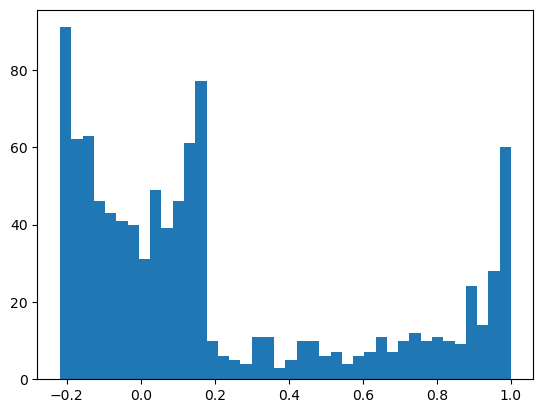

In [55]:
plt.hist( corr_array, bins=40)
plt.show

In [56]:
df0 = mc_pts[:,0] - mc_pts[point_index,0]

deltaf = mc_pts[:,:] - mc_pts[point_index,:]

dr2 = np.zeros( len(deltaf) )
for fi in range(0,ndim) :
    dr2 += deltaf[:,fi] * deltaf[:,fi]
dr = np.sqrt( dr2 )



<function matplotlib.pyplot.show(close=None, block=None)>

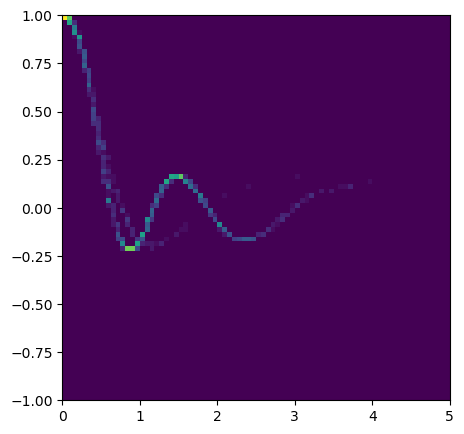

In [57]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

ax.hist2d( dr[:ncalc], corr_array, bins=[80,80], range=([0,5],[-1,1]))
plt.show

In [58]:
%%time



for point_index in range(npoints) :
    
    if (point_index % (npoints/10) == 0 ) :
        print(" Working on point %3d" % point_index)
        
    this_point_corr_array = np.zeros(ncalc)
    
    for i in range(ncalc) :
        #if i == point_index : continue
        pair_cor = np.corrcoef( np.row_stack( (bootstrap_weights[:,point_index], bootstrap_weights[:,i]) ))
        this_point_corr_array[i] = pair_cor[0,1]
    
    if point_index == 0 :
        all_points_df0 = mc_pts[:ncalc,0] - mc_pts[point_index,0]

        all_points_deltaf = mc_pts[:ncalc,:] - mc_pts[point_index,:]
        dr2 = np.zeros( len(all_points_deltaf) )
        for fi in range(0,ndim) :
            dr2 += all_points_deltaf[:,fi] * all_points_deltaf[:,fi]
        all_points_dr = np.sqrt( dr2 )
        all_points_corr_array = this_point_corr_array
        all_points_f0b = mc_pts[:ncalc,0]

        all_points_coords = mc_pts[:ncalc,:]
    else :
        this_point_df0 = mc_pts[:ncalc,0] - mc_pts[point_index,0]

        this_point_deltaf = mc_pts[:ncalc,:] - mc_pts[point_index,:]
        dr2 = np.zeros( len(this_point_deltaf) )
        for fi in range(0,ndim) :
            dr2 += this_point_deltaf[:,fi] * this_point_deltaf[:,fi]
        all_points_dr = np.append( all_points_dr, np.sqrt( dr2 ) )       
        
        all_points_df0 = np.append( all_points_df0, this_point_df0 )

        all_points_corr_array = np.append(all_points_corr_array, this_point_corr_array)
        all_points_f0b = np.append(all_points_f0b, mc_pts[:ncalc,0] )

        all_points_coords = np.append( all_points_coords, mc_pts[:ncalc,:], axis=0 )


 Working on point   0
 Working on point 100
 Working on point 200
 Working on point 300
 Working on point 400
 Working on point 500
 Working on point 600
 Working on point 700
 Working on point 800
 Working on point 900
CPU times: user 52.5 s, sys: 5.55 s, total: 58.1 s
Wall time: 57.8 s


<function matplotlib.pyplot.show(close=None, block=None)>

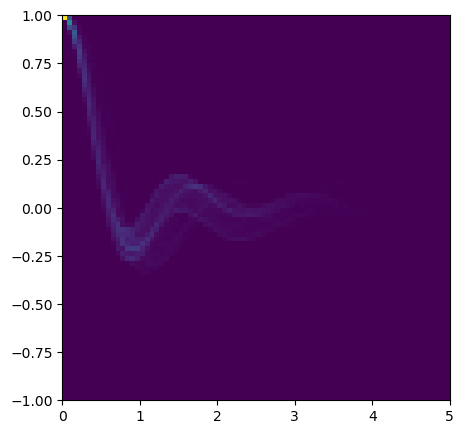

In [59]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

hd = ax.hist2d( all_points_dr, all_points_corr_array, bins=[80,80], range=([0,5],[-1,1]))


plt.show

In [60]:
def profile2d_from_hdata( axis, hist_data,  drawline=True, hlabel="", mstyle='o' ) :
    
        
    nybins = len(hist_data[0][0])
    print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins-1 ) :  # don't include the y-bin that corresponds to rho=1 (event with itself)
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, marker='%s' % mstyle, label=hlabel)
    

    
    plt.show
    


number of y bins: 80
number of x bins: 80


/tmp/ipykernel_3122468/3416627860.py:33: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_3122468/3416627860.py:34: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

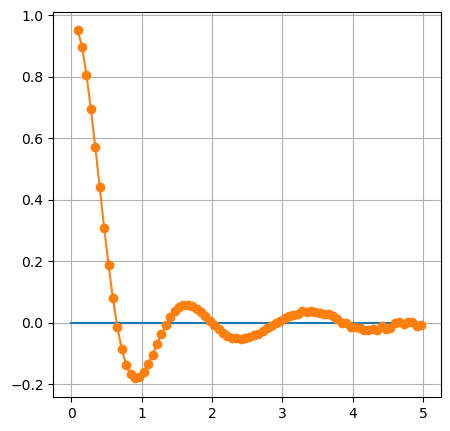

In [61]:
fig,ax = plt.subplots( 1, 1, figsize=(5,5))

profile2d_from_hdata( ax, hd )

ax.grid(True)

plt.show

In [62]:
with open( '%s/correlations.npy' % input_unfolding_dir, 'wb') as f :
    np.save(f, all_points_df0)
    np.save(f, all_points_dr)
    np.save(f, all_points_corr_array)

with open( '%s/correlation-points-feature-coords.npy' % input_unfolding_dir, 'wb') as f :
    np.save(f, all_points_f0b)
    np.save(f, all_points_coords)
    

In [63]:
if ndim > 1 :
    print('\n\n\n Skipping the rest, which is only for 1d.\n\n')
    sys.exit()

## Do the binned chi2 fits

In [64]:

if use_uniform_fit_hist_binning :
    
    fitting_hist_bins = np.linspace( uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins+1 )
    fitting_hist_bin_widths = fitting_hist_bins[1:] - fitting_hist_bins[0:-1]
    fitting_hist_bin_centers = 0.5 * ( fitting_hist_bins[1:] + fitting_hist_bins[0:-1] )
    fitting_hist_n_bins = uniform_fit_hist_nbins
    
    print('\n\n Using uniform fit hist binning:  %.4f to %.4f in %d bins' % (
    uniform_fit_hist_xlow, uniform_fit_hist_xhigh, uniform_fit_hist_nbins))
    
    print('\n\n fitting_hist_bins calculated : %s\n\n' % str(fitting_hist_bins))
    
else :

    binning_file = '%s/binning.npy' % sample_input_dir

    with open(binning_file,'rb') as f :
        fitting_hist_bins = np.load(f)
        fitting_hist_bin_widths = np.load(f)
        fitting_hist_bin_centers = np.load(f)
        fitting_hist_n_bins = np.load(f)

    print('\n\n fitting_hist_bins read from file : %s\n\n' % str(fitting_hist_bins))
    
print(' fitting_hist_n_bins  %d' % fitting_hist_n_bins )




 Using uniform fit hist binning:  -3.0000 to 4.0000 in 15 bins


 fitting_hist_bins calculated : [-3.         -2.53333333 -2.06666667 -1.6        -1.13333333 -0.66666667
 -0.2         0.26666667  0.73333333  1.2         1.66666667  2.13333333
  2.6         3.06666667  3.53333333  4.        ]


 fitting_hist_n_bins  15


 boot   0 weights: [0.11428974 0.09193321 0.09471507 ... 0.11041879 0.11626814 0.08698262]
 boot   1 weights: [0.11991243 0.08954016 0.09295522 ... 0.1139508  0.11877771 0.08433323]
 boot   2 weights: [0.12263551 0.08547915 0.08947734 ... 0.11383704 0.11620012 0.08026313]
 boot   3 weights: [0.12758346 0.08391374 0.08795069 ... 0.11528468 0.11973743 0.07819718]
 boot   4 weights: [0.11065723 0.08501955 0.08800032 ... 0.11061266 0.11883124 0.08029979]
 boot   5 weights: [0.11235074 0.08378517 0.086392   ... 0.11043943 0.114431   0.08014345]
 boot   6 weights: [0.11692859 0.08965768 0.09281386 ... 0.11438635 0.11632707 0.08546587]
 boot   7 weights: [0.11881402 0.09069552 0.0932745  ... 0.11023618 0.11343578 0.0865491 ]
 boot   8 weights: [0.1305707  0.08711499 0.08997802 ... 0.1155502  0.12092856 0.08324332]
 boot   9 weights: [0.1132078  0.08928936 0.09233451 ... 0.10952841 0.11221869 0.08424542]
 boot  10 weights: [0.1118337  0.08726812 0.09089057 ... 0.10862995 0.11212725 0.08121649]

 boot  96 weights: [0.12106122 0.0839625  0.08794766 ... 0.10853266 0.10678976 0.07873043]
 boot  97 weights: [0.11400008 0.09131661 0.09412536 ... 0.11132589 0.11630406 0.08666948]
 boot  98 weights: [0.12109313 0.08675115 0.09041054 ... 0.11163202 0.11637194 0.081053  ]
 boot  99 weights: [0.12007398 0.08434315 0.0864142  ... 0.11224697 0.1177018  0.08103024]
 boot 100 weights: [0.11670875 0.08863201 0.09199019 ... 0.1137818  0.11931481 0.08322378]
 boot 101 weights: [0.1236324  0.08313685 0.08581333 ... 0.11765339 0.1216476  0.07988415]
 boot 102 weights: [0.12297311 0.08008979 0.0836988  ... 0.1180832  0.11886431 0.07597746]
 boot 103 weights: [0.11313741 0.09243341 0.09511288 ... 0.1138652  0.11963041 0.08804019]
 boot 104 weights: [0.1240555  0.08532046 0.08921272 ... 0.11585542 0.11555536 0.0798642 ]
 boot 105 weights: [0.12649902 0.09142829 0.0944652  ... 0.11091265 0.11382649 0.08643778]
 boot 106 weights: [0.12068154 0.08806575 0.09223663 ... 0.11297883 0.11581955 0.08168298]

 boot 187 weights: [0.11398421 0.09055013 0.09307491 ... 0.10840877 0.11291378 0.08619824]
 boot 188 weights: [0.13145894 0.0874963  0.09113389 ... 0.1140766  0.11814985 0.08179781]
 boot 189 weights: [0.12960251 0.09214205 0.0951689  ... 0.10886878 0.11112744 0.08701992]
 boot 190 weights: [0.11670494 0.08914828 0.09100604 ... 0.10675269 0.11234085 0.0862945 ]
 boot 191 weights: [0.12585917 0.08910365 0.09074604 ... 0.11546892 0.11628701 0.08603353]
 boot 192 weights: [0.12172151 0.08184499 0.08520228 ... 0.11354604 0.11669035 0.07777636]
 boot 193 weights: [0.12429579 0.08592856 0.08890883 ... 0.10819768 0.11488371 0.08107136]
 boot 194 weights: [0.11416623 0.0872466  0.09042251 ... 0.1129081  0.11846333 0.08234777]
 boot 195 weights: [0.12288185 0.08849854 0.09141373 ... 0.11269408 0.11714608 0.08380164]
 boot 196 weights: [0.12216552 0.08957934 0.09168349 ... 0.10610399 0.11314549 0.08578314]
 boot 197 weights: [0.12023177 0.08746302 0.09006461 ... 0.10885156 0.11574019 0.08360322]

 boot 289 weights: [0.12450447 0.08974124 0.09291287 ... 0.10917622 0.11332732 0.08424812]
 boot 290 weights: [0.12435081 0.08834796 0.09193043 ... 0.11298623 0.11611607 0.08255042]
 boot 291 weights: [0.10982487 0.08873196 0.09158906 ... 0.11221017 0.12018285 0.08408598]
 boot 292 weights: [0.12255758 0.08676003 0.08962708 ... 0.11307348 0.11417685 0.08298701]
 boot 293 weights: [0.11674476 0.08339969 0.08702362 ... 0.1127384  0.11625969 0.07826823]
 boot 294 weights: [0.11891305 0.08191769 0.08390897 ... 0.10734551 0.11533914 0.0793204 ]
 boot 295 weights: [0.12372299 0.0876383  0.08975937 ... 0.10998055 0.11950591 0.08439762]
 boot 296 weights: [0.11534763 0.08643243 0.08895008 ... 0.10932752 0.11406065 0.08265555]
 boot 297 weights: [0.11966042 0.08891824 0.09117916 ... 0.11126182 0.11977865 0.0852669 ]
 boot 298 weights: [0.12183381 0.08870028 0.09201177 ... 0.11331964 0.11580613 0.08365772]
 boot 299 weights: [0.11739828 0.08632388 0.08954726 ... 0.11501317 0.12012403 0.08161419]

 boot 381 weights: [0.10734111 0.08105415 0.08395405 ... 0.10978282 0.11738205 0.07712578]
 boot 382 weights: [0.12179227 0.09231441 0.09546612 ... 0.11457412 0.11796315 0.08722787]
 boot 383 weights: [0.11265993 0.09013176 0.09342951 ... 0.11008485 0.1150354  0.08444343]
 boot 384 weights: [0.11677441 0.08862367 0.09151235 ... 0.11234244 0.11803452 0.08411608]
 boot 385 weights: [0.12152126 0.08766038 0.09047282 ... 0.11188638 0.11871487 0.08335017]
 boot 386 weights: [0.12596386 0.08533512 0.08887819 ... 0.11301548 0.11936388 0.07980293]
 boot 387 weights: [0.12139281 0.08992395 0.09273283 ... 0.10837677 0.11362129 0.08516308]
 boot 388 weights: [0.1230076  0.08559746 0.08784393 ... 0.10923137 0.11662833 0.08228986]
 boot 389 weights: [0.11567703 0.08249407 0.08598326 ... 0.11335863 0.11880318 0.07747454]
 boot 390 weights: [0.11263536 0.08903595 0.09160571 ... 0.10575025 0.11074278 0.08454758]
 boot 391 weights: [0.12483124 0.09118178 0.09439121 ... 0.11102974 0.11518876 0.08573901]

 boot 477 weights: [0.12234877 0.09212182 0.09443402 ... 0.10867473 0.11617399 0.08769152]
 boot 478 weights: [0.11675766 0.08935414 0.09280299 ... 0.10792383 0.10957254 0.08379099]
 boot 479 weights: [0.11747556 0.08607363 0.09040795 ... 0.11700695 0.11763594 0.0799387 ]
 boot 480 weights: [0.11996501 0.08975579 0.09333781 ... 0.1157732  0.12124926 0.0840313 ]
 boot 481 weights: [0.12024483 0.08740698 0.09021087 ... 0.11289425 0.11698671 0.0833636 ]
 boot 482 weights: [0.12391101 0.08948515 0.09259646 ... 0.10923916 0.1140723  0.08395575]
 boot 483 weights: [0.12375348 0.09147824 0.09454958 ... 0.10974253 0.11364072 0.08615159]
 boot 484 weights: [0.12313962 0.08790951 0.09113746 ... 0.1107564  0.11492605 0.08291233]
 boot 485 weights: [0.11520545 0.0870348  0.08974016 ... 0.10808446 0.11535617 0.08255434]
 boot 486 weights: [0.11505938 0.08682286 0.08959549 ... 0.10906917 0.11534012 0.08257576]
 boot 487 weights: [0.11492438 0.08792417 0.09046481 ... 0.1091542  0.11579849 0.08377536]

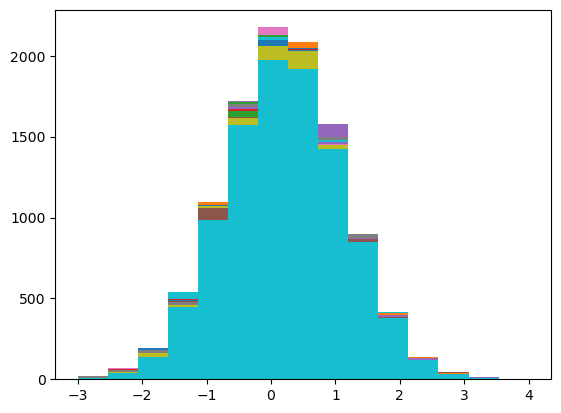

In [65]:
boot_hist_content = np.zeros( shape=(n_samples, fitting_hist_n_bins ))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :

    if samples_from_GenerateInput :
        
        rd = read_sample( sample_input_dir, bi )

        ngen_true = rd['ngen_true']
        ngen_mc = rd['ngen_mc']


        true_det_pts = rd['true_det_pts']
        mc_pts = rd['mc_pts']
        mc_det_pts = rd['mc_det_pts']
    
    
            
    fname = '%s/bootstrap-weights-%03d.npy' % (input_unfolding_dir, bi)

    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue

    with open(fname,'rb') as f :            

        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)

        of_weight_sum[bi] = np.sum( final_push_weights_scaled )

        hist_content,_,_ = plt.hist( mc_pts[:,0], bins=fitting_hist_bins, weights=final_push_weights_scaled )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content


        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
        
        
        

<function matplotlib.pyplot.show(close=None, block=None)>

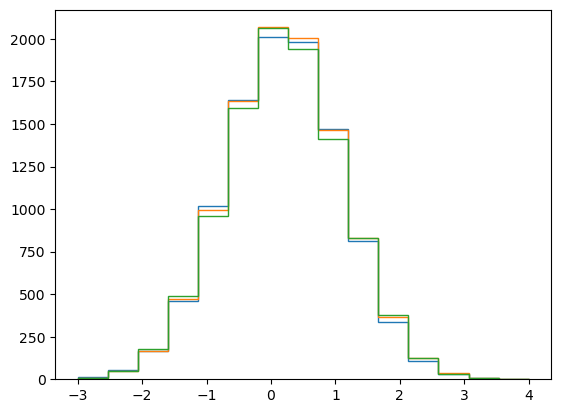

In [66]:
plt.stairs( boot_hist_content[0,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[1,:], edges=fitting_hist_bins )
plt.stairs( boot_hist_content[2,:], edges=fitting_hist_bins )
plt.show

In [67]:
with open( '%s/binned-output-histograms.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, boot_hist_content )


In [68]:
hist_nbins = fitting_hist_n_bins


hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [69]:
#hist_corr_mat[0,hist_nbins-1] = -1.

In [70]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
#hist_cov_mat_copy = np.copy( hist_cov_mat )
#hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -346.53 , 2322.70




<function matplotlib.pyplot.show(close=None, block=None)>

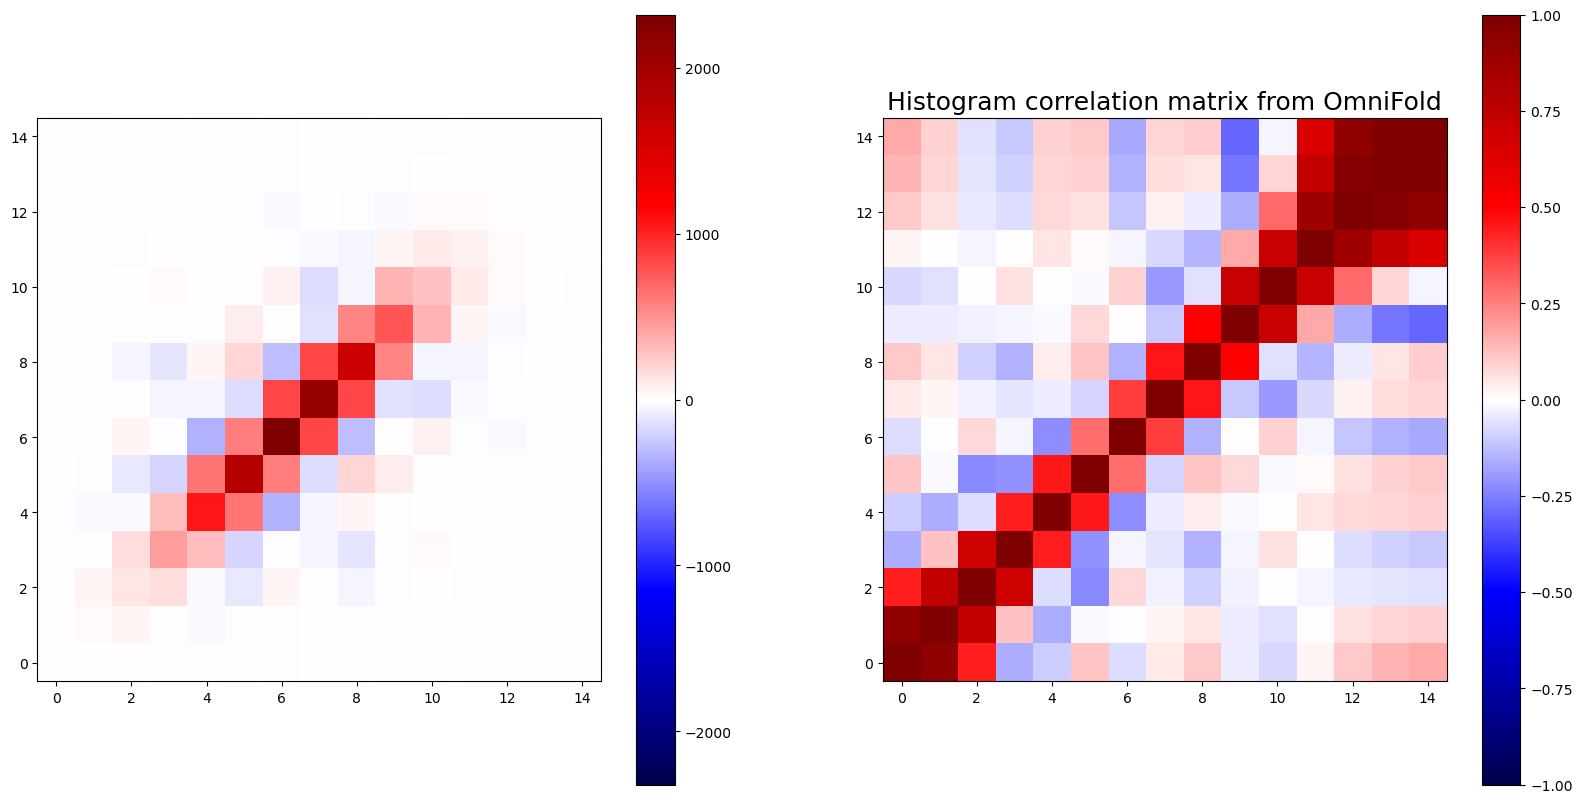

In [71]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, 
                         vmin=-1*max_cov_element, vmax=max_cov_element,
                         cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, 
                  vmin=-1, vmax=1,
                  cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [72]:
with open( '%s/binned-cov-and-cor-mats.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, hist_cov_mat )
    np.save( f, hist_corr_mat )

In [73]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )

In [74]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [75]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )

In [76]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

#hist_cov_inv_copy = np.copy( hist_cov_inv )
#hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max



 min and max of covariance matrix inverse:  -0.36  0.99




<function matplotlib.pyplot.show(close=None, block=None)>

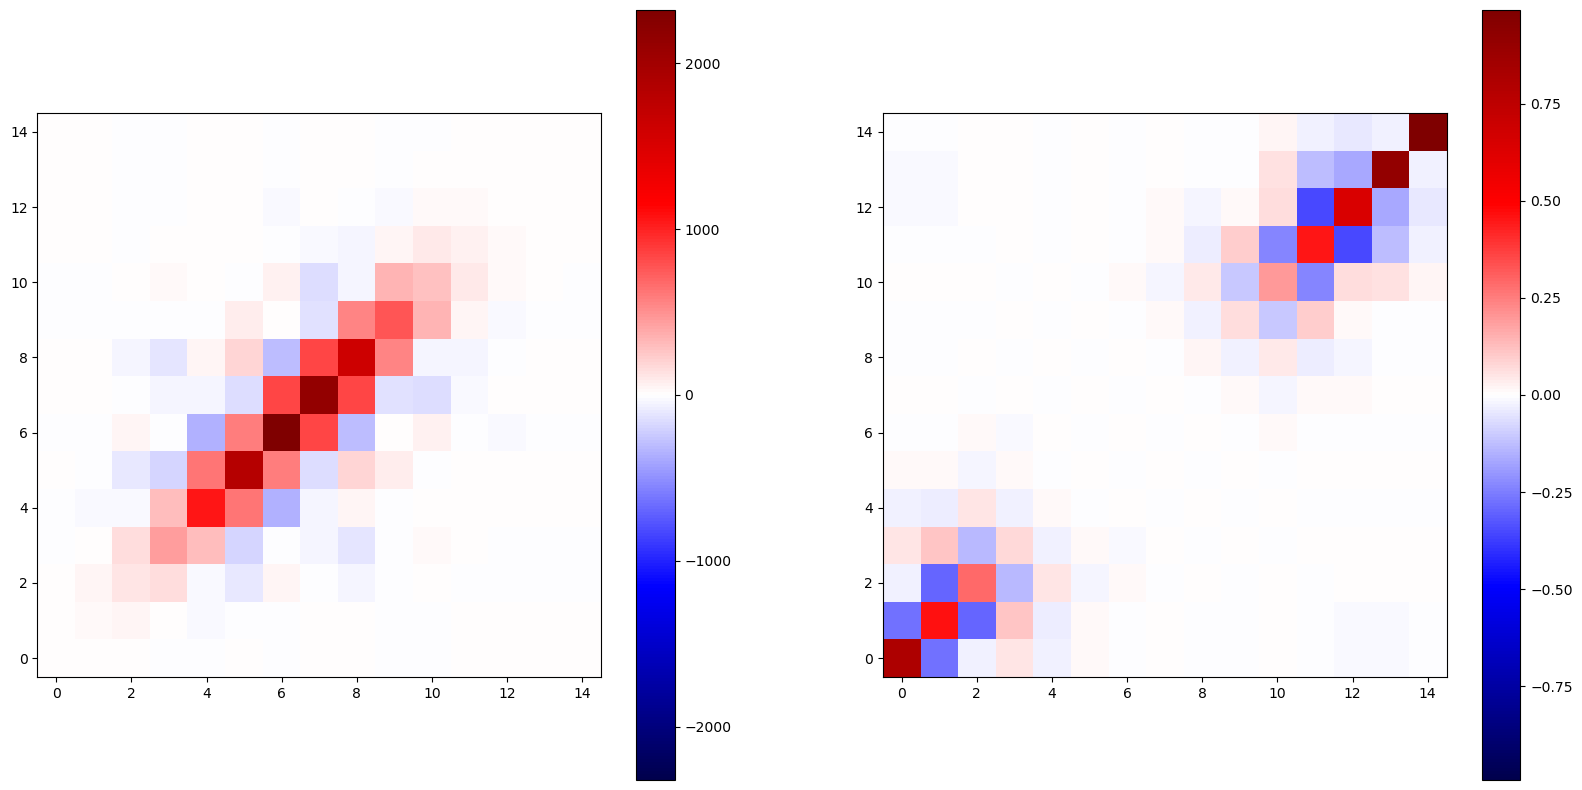

In [77]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, 
                         vmin=-1*max_cov_element, vmax=max_cov_element,
                         cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv, 
                  vmin=-1*ci_max, vmax=ci_max,
                  cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [78]:

hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )


In [79]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

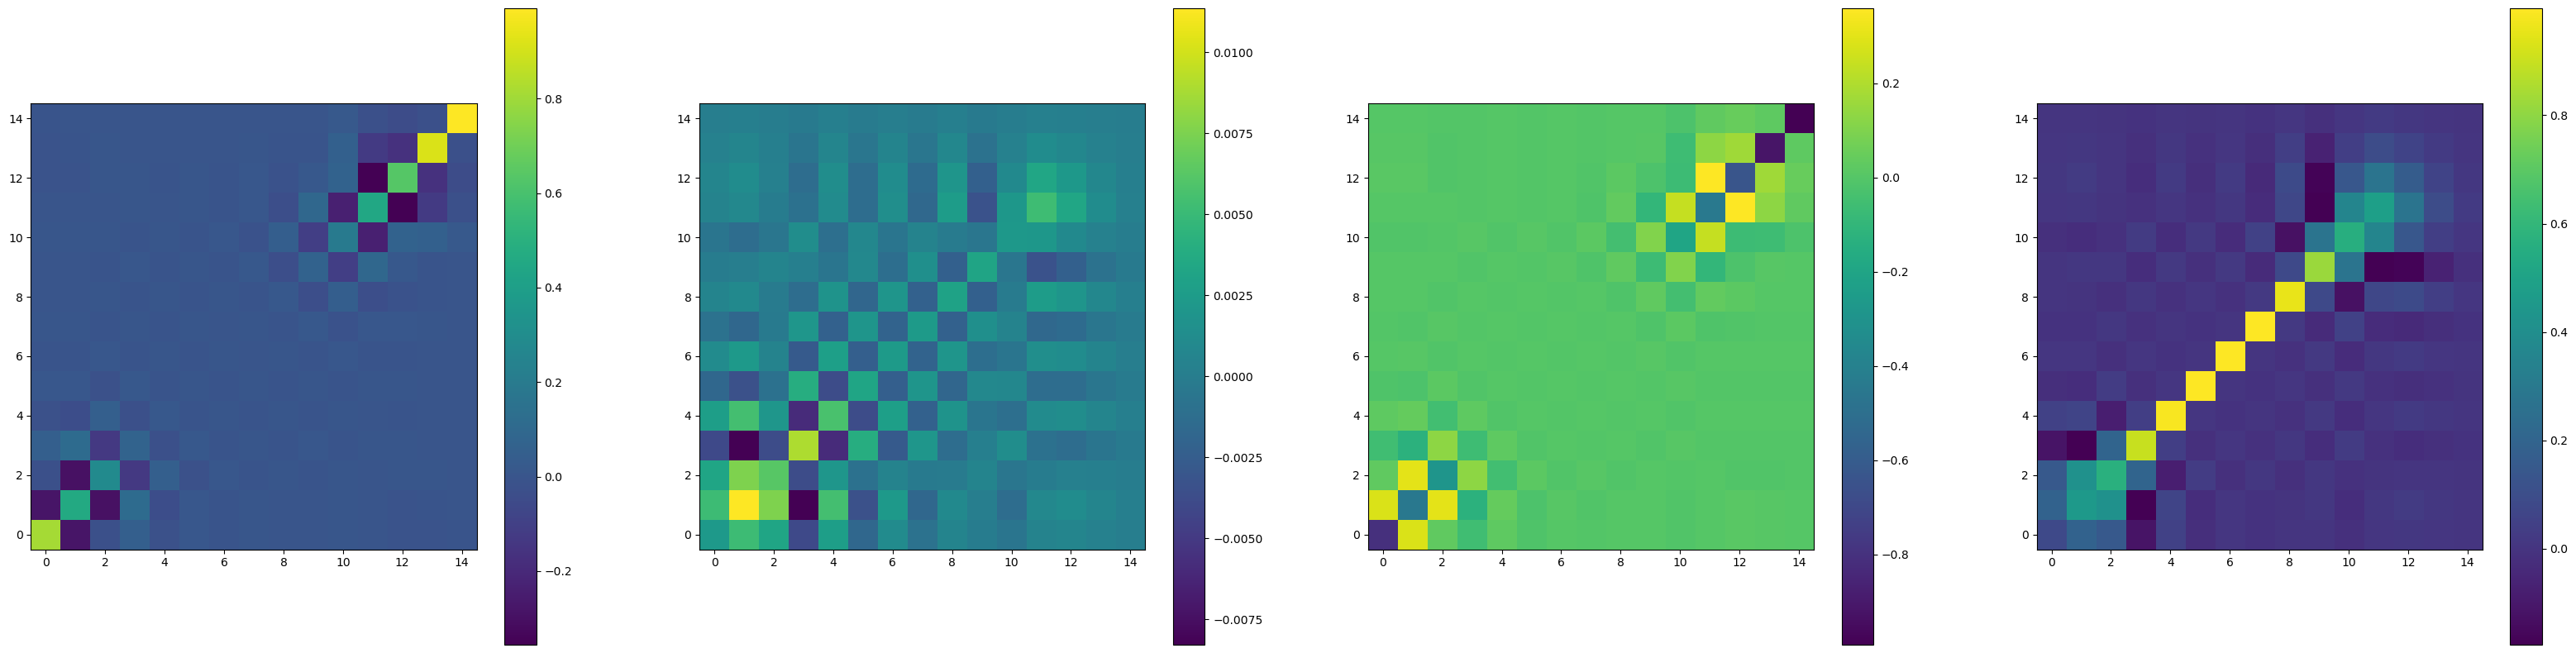

In [80]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [81]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

#hist_cov_pinv_copy = np.copy( hist_cov_pinv )
#hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.01  0.01




<function matplotlib.pyplot.show(close=None, block=None)>

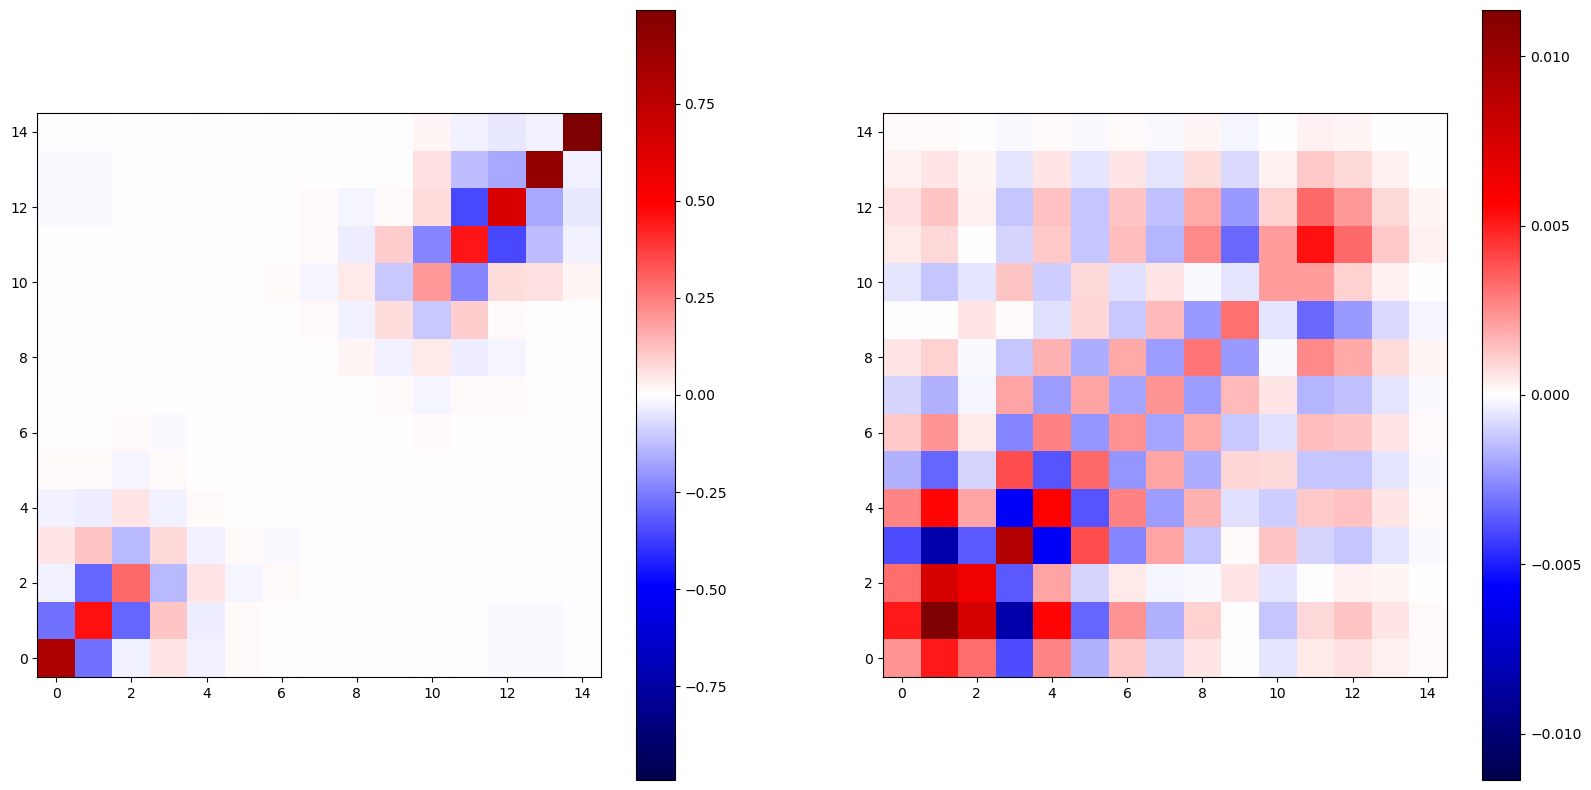

In [82]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv, 
                         vmin=-1*ci_max, vmax=ci_max,
                         cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv, 
                  vmin=-1*cpi_max, vmax=cpi_max,
                  cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [83]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

from scipy import special


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [84]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [85]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], fitting_hist_bins, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1865 +/-   0.0117  (  0.1848 +/-   0.0084)    sig2   0.7982 +/-   0.0156  (  0.8026 +/-   0.0103)
   1 : mu   0.2065 +/-   0.0115  (  0.2084 +/-   0.0083)    sig2   0.8027 +/-   0.0154  (  0.8120 +/-   0.0101)
   2 : mu   0.2010 +/-   0.0117  (  0.2002 +/-   0.0084)    sig2   0.8150 +/-   0.0155  (  0.8217 +/-   0.0101)
   3 : mu   0.2310 +/-   0.0116  (  0.2286 +/-   0.0083)    sig2   0.8061 +/-   0.0157  (  0.8139 +/-   0.0102)
   4 : mu   0.2097 +/-   0.0119  (  0.2059 +/-   0.0086)    sig2   0.7786 +/-   0.0160  (  0.7833 +/-   0.0106)
   5 : mu   0.1946 +/-   0.0122  (  0.1950 +/-   0.0088)    sig2   0.7958 +/-   0.0163  (  0.8036 +/-   0.0106)
   6 : mu   0.1772 +/-   0.0116  (  0.1768 +/-   0.0084)    sig2   0.7920 +/-   0.0152  (  0.7959 +/-   0.0100)
   7 : mu   0.1812 +/-   0.0119  (  0.1830 +/-   0.0085)    sig2   0.7987 +/-   0.0155  (  0.8015 +/-   0.0101)
   8 : mu   0.2146 +/-   0.0114  (  0.2135 +/-   0.0082)    sig2   0.8123 +/-   0.0150  (  0.8141 +/-   

 102 : mu   0.2080 +/-   0.0117  (  0.2067 +/-   0.0083)    sig2   0.8339 +/-   0.0163  (  0.8474 +/-   0.0103)
 103 : mu   0.1720 +/-   0.0115  (  0.1706 +/-   0.0082)    sig2   0.8172 +/-   0.0156  (  0.8250 +/-   0.0102)
 104 : mu   0.2009 +/-   0.0119  (  0.2031 +/-   0.0086)    sig2   0.7922 +/-   0.0159  (  0.7976 +/-   0.0103)
 105 : mu   0.1903 +/-   0.0117  (  0.1918 +/-   0.0084)    sig2   0.8170 +/-   0.0153  (  0.8167 +/-   0.0100)
 106 : mu   0.2016 +/-   0.0117  (  0.2017 +/-   0.0085)    sig2   0.7887 +/-   0.0155  (  0.7926 +/-   0.0102)
 107 : mu   0.1968 +/-   0.0117  (  0.1955 +/-   0.0084)    sig2   0.8020 +/-   0.0154  (  0.8065 +/-   0.0101)
 108 : mu   0.2248 +/-   0.0117  (  0.2274 +/-   0.0084)    sig2   0.7911 +/-   0.0154  (  0.7950 +/-   0.0101)
 109 : mu   0.2118 +/-   0.0115  (  0.2108 +/-   0.0083)    sig2   0.7915 +/-   0.0151  (  0.7922 +/-   0.0099)
 110 : mu   0.1929 +/-   0.0117  (  0.1923 +/-   0.0084)    sig2   0.7927 +/-   0.0153  (  0.7952 +/-   

 179 : mu   0.1994 +/-   0.0116  (  0.1989 +/-   0.0083)    sig2   0.8273 +/-   0.0153  (  0.8297 +/-   0.0099)
 180 : mu   0.1979 +/-   0.0116  (  0.2015 +/-   0.0084)    sig2   0.7928 +/-   0.0151  (  0.7988 +/-   0.0099)
 181 : mu   0.1985 +/-   0.0117  (  0.2020 +/-   0.0084)    sig2   0.8183 +/-   0.0153  (  0.8210 +/-   0.0100)
 182 : mu   0.2031 +/-   0.0119  (  0.2032 +/-   0.0084)    sig2   0.8398 +/-   0.0161  (  0.8466 +/-   0.0103)
 183 : mu   0.1980 +/-   0.0114  (  0.2001 +/-   0.0083)    sig2   0.7796 +/-   0.0151  (  0.7847 +/-   0.0100)
 184 : mu   0.1881 +/-   0.0118  (  0.1909 +/-   0.0085)    sig2   0.7987 +/-   0.0156  (  0.8044 +/-   0.0103)
 185 : mu   0.2031 +/-   0.0118  (  0.2010 +/-   0.0085)    sig2   0.8059 +/-   0.0160  (  0.8120 +/-   0.0104)
 186 : mu   0.2084 +/-   0.0119  (  0.2056 +/-   0.0085)    sig2   0.8037 +/-   0.0158  (  0.8039 +/-   0.0103)
 187 : mu   0.1843 +/-   0.0120  (  0.1865 +/-   0.0086)    sig2   0.7989 +/-   0.0158  (  0.8023 +/-   

 278 : mu   0.2083 +/-   0.0119  (  0.2104 +/-   0.0086)    sig2   0.8017 +/-   0.0159  (  0.8039 +/-   0.0103)
 279 : mu   0.1902 +/-   0.0121  (  0.1941 +/-   0.0087)    sig2   0.7961 +/-   0.0160  (  0.8032 +/-   0.0105)
 280 : mu   0.1886 +/-   0.0119  (  0.1904 +/-   0.0086)    sig2   0.7888 +/-   0.0158  (  0.7936 +/-   0.0103)
 281 : mu   0.1727 +/-   0.0118  (  0.1722 +/-   0.0085)    sig2   0.7856 +/-   0.0160  (  0.7961 +/-   0.0105)
 282 : mu   0.1936 +/-   0.0119  (  0.1933 +/-   0.0086)    sig2   0.7994 +/-   0.0157  (  0.8011 +/-   0.0103)
 283 : mu   0.1905 +/-   0.0117  (  0.1920 +/-   0.0084)    sig2   0.8066 +/-   0.0156  (  0.8113 +/-   0.0102)
 284 : mu   0.1927 +/-   0.0118  (  0.1916 +/-   0.0085)    sig2   0.8009 +/-   0.0155  (  0.8063 +/-   0.0101)
 285 : mu   0.1929 +/-   0.0118  (  0.1881 +/-   0.0084)    sig2   0.8050 +/-   0.0156  (  0.8089 +/-   0.0102)
 286 : mu   0.2140 +/-   0.0117  (  0.2142 +/-   0.0085)    sig2   0.8046 +/-   0.0157  (  0.8119 +/-   

 354 : mu   0.2044 +/-   0.0119  (  0.2050 +/-   0.0086)    sig2   0.7951 +/-   0.0158  (  0.8011 +/-   0.0104)
 355 : mu   0.2086 +/-   0.0115  (  0.2119 +/-   0.0083)    sig2   0.7898 +/-   0.0154  (  0.7960 +/-   0.0101)
 356 : mu   0.2119 +/-   0.0119  (  0.2083 +/-   0.0086)    sig2   0.7851 +/-   0.0159  (  0.7869 +/-   0.0104)
 357 : mu   0.1929 +/-   0.0116  (  0.1913 +/-   0.0083)    sig2   0.8216 +/-   0.0152  (  0.8256 +/-   0.0099)
 358 : mu   0.2230 +/-   0.0118  (  0.2280 +/-   0.0085)    sig2   0.8158 +/-   0.0158  (  0.8212 +/-   0.0102)
 359 : mu   0.1861 +/-   0.0119  (  0.1806 +/-   0.0085)    sig2   0.8148 +/-   0.0158  (  0.8187 +/-   0.0104)
 360 : mu   0.1925 +/-   0.0118  (  0.1935 +/-   0.0084)    sig2   0.8254 +/-   0.0160  (  0.8360 +/-   0.0104)
 361 : mu   0.1983 +/-   0.0115  (  0.1961 +/-   0.0083)    sig2   0.7778 +/-   0.0151  (  0.7818 +/-   0.0100)
 362 : mu   0.2226 +/-   0.0118  (  0.2220 +/-   0.0084)    sig2   0.8150 +/-   0.0157  (  0.8172 +/-   

 454 : mu   0.1861 +/-   0.0120  (  0.1806 +/-   0.0086)    sig2   0.8141 +/-   0.0160  (  0.8156 +/-   0.0104)
 455 : mu   0.1983 +/-   0.0117  (  0.1971 +/-   0.0084)    sig2   0.7962 +/-   0.0155  (  0.7986 +/-   0.0101)
 456 : mu   0.2192 +/-   0.0116  (  0.2256 +/-   0.0084)    sig2   0.7936 +/-   0.0158  (  0.8054 +/-   0.0104)
 457 : mu   0.2028 +/-   0.0116  (  0.2039 +/-   0.0083)    sig2   0.8249 +/-   0.0156  (  0.8297 +/-   0.0101)
 458 : mu   0.2048 +/-   0.0118  (  0.2040 +/-   0.0086)    sig2   0.7657 +/-   0.0158  (  0.7689 +/-   0.0104)
 459 : mu   0.1936 +/-   0.0119  (  0.1978 +/-   0.0087)    sig2   0.7770 +/-   0.0154  (  0.7786 +/-   0.0102)
 460 : mu   0.2067 +/-   0.0118  (  0.2061 +/-   0.0086)    sig2   0.7925 +/-   0.0160  (  0.8002 +/-   0.0104)
 461 : mu   0.2047 +/-   0.0119  (  0.2039 +/-   0.0085)    sig2   0.8308 +/-   0.0159  (  0.8356 +/-   0.0103)
 462 : mu   0.2057 +/-   0.0119  (  0.2073 +/-   0.0086)    sig2   0.7944 +/-   0.0159  (  0.8001 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

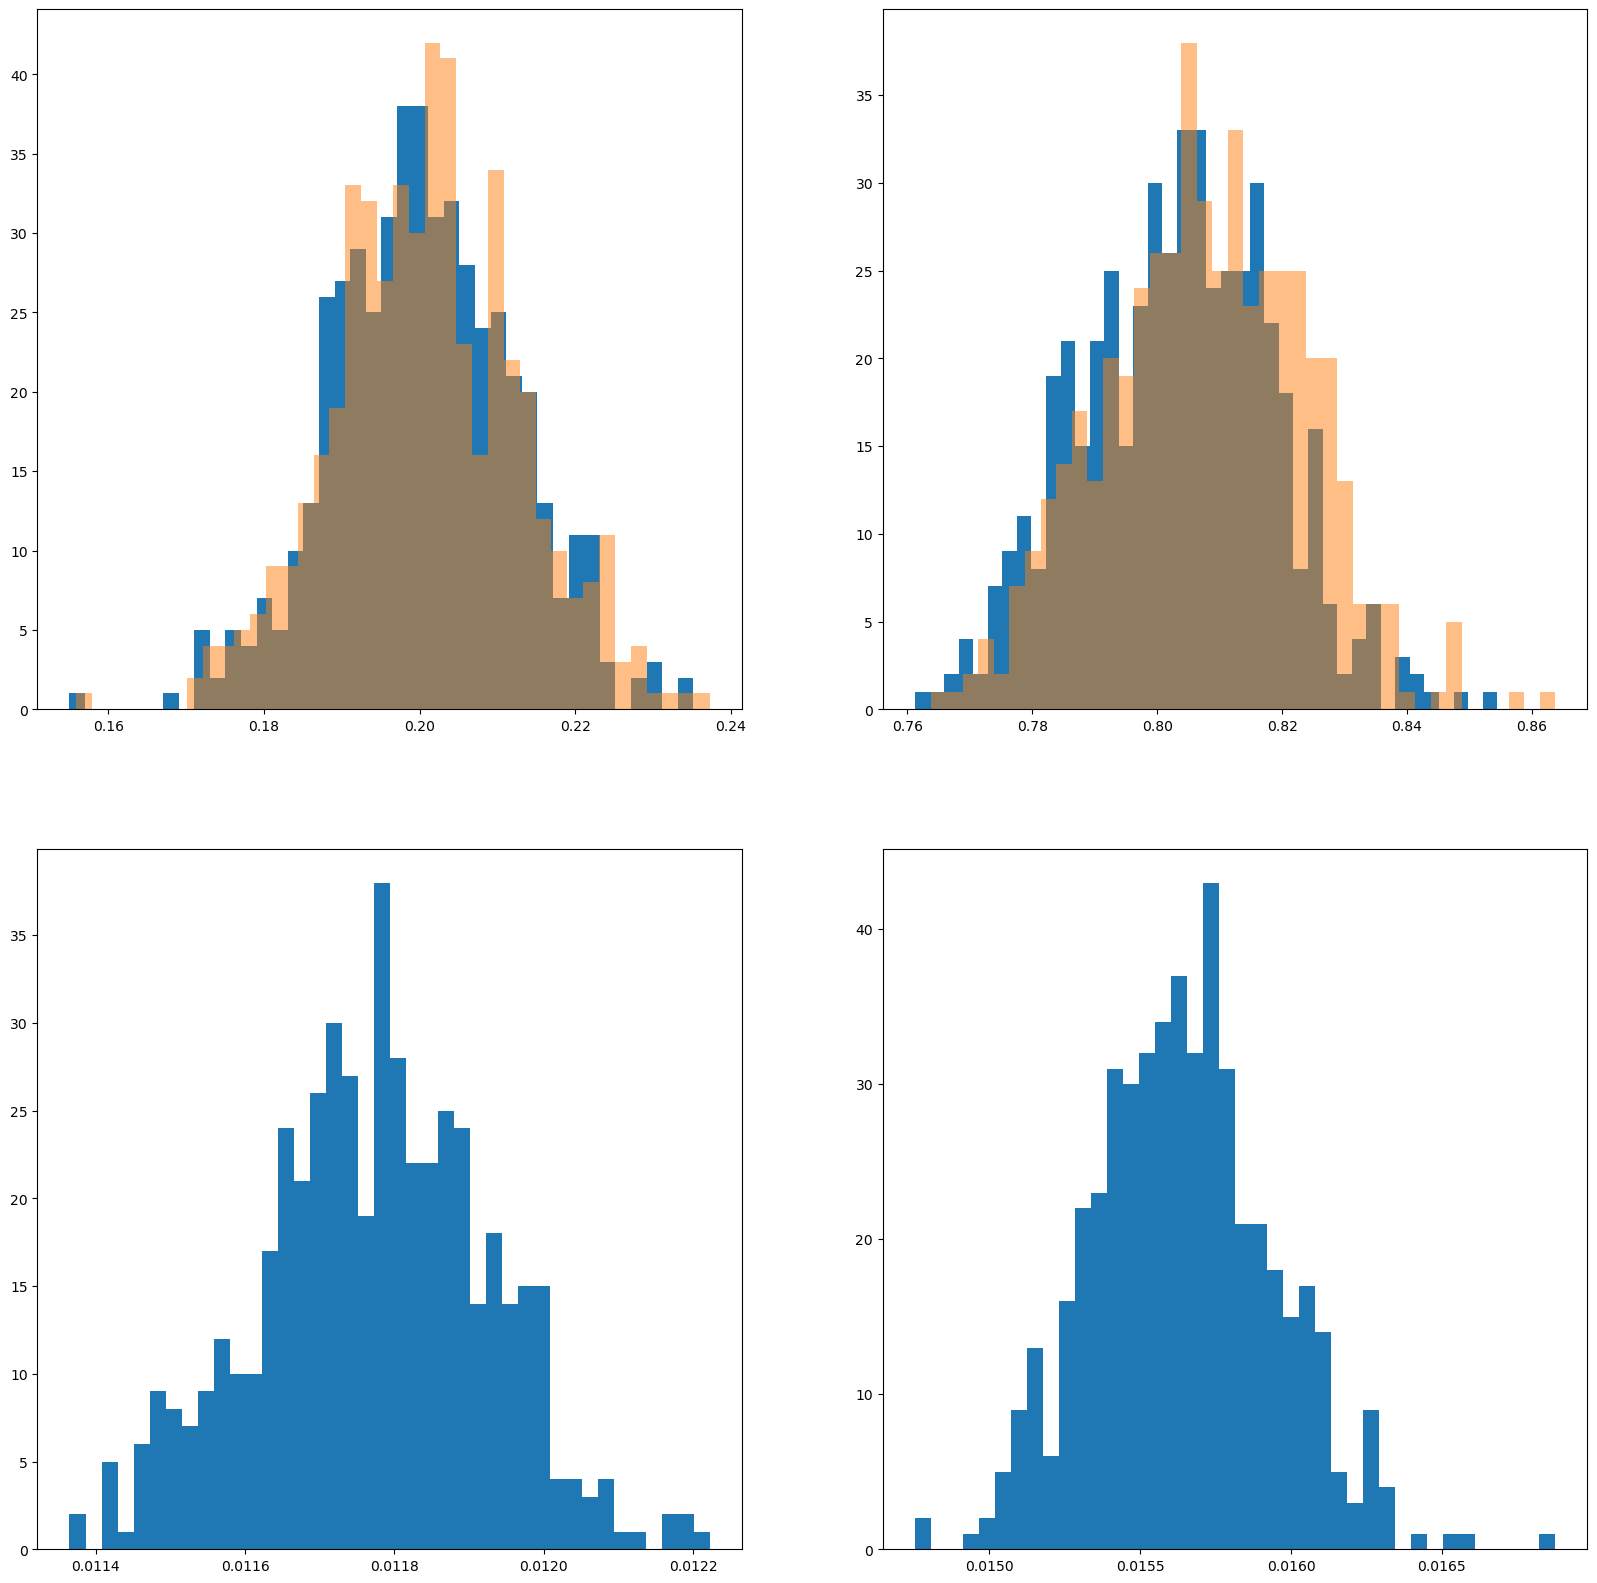

In [86]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [87]:


mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')





 mean:  0.2005, rms  0.0117, mean fit err  0.0118  |  diag. chi2 fit    0.2009, rms  0.0121, mean fit err  0.0085
 sig2:  0.8032, rms  0.0155, mean fit err  0.0156  |  diag. chi2 fit    0.8077, rms  0.0160, mean fit err  0.0102





In [88]:
with open( '%s/chi2-fit-results.npy' % input_unfolding_dir, 'wb' ) as f :
    np.save( f, chi2_fit_mu_val )
    np.save( f, chi2_fit_sig2_val )
    np.save( f, chi2_fit_mu_err )
    np.save( f, chi2_fit_sig2_err )
    np.save( f, chi2_fit_diag_mu_val )
    np.save( f, chi2_fit_diag_sig2_val )
    np.save( f, chi2_fit_diag_mu_err )
    np.save( f, chi2_fit_diag_sig2_err )
    
    
    
    

In [89]:
print('\n\n Done \n\n')



 Done 


